# Project Overview:
This notebook is part of the "Traffic-Potential-Forecasting-End-to-End-ML-Project". The key principles guiding the development of this notebook are:
- **Modularity**: Structuring the code into independent, interchangeable modules to enhance maintainability and scalability.
- **Reusability**: Emphasizing code reusability to promote efficient use of resources and time.
- **Efficiency**: Continuously refining the code for optimal performance and resource utilization.

In [1]:
# Importing libraries for data handling, analysis, and visualization
import pandas as pd                             # Data manipulation and analysis
import numpy as np                              # Numerical computations
import matplotlib.pyplot as plt                 # Basic plotting and visualization
import seaborn as sns                           # Advanced data visualization
import plotly.express as px                     # Interactive plotting

# Statistical and mathematical utilities
from scipy.spatial import distance              # Spatial distance functions
from scipy.stats import boxcox, randint, uniform # Statistical functions

# Machine learning utilities from scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV  # Data splitting and hyperparameter tuning
from sklearn.preprocessing import LabelEncoder   # Encoding categorical variables
from sklearn.metrics import (                    # Model evaluation metrics
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    mean_squared_error, log_loss, roc_curve, auc, classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance  # Feature importance evaluation

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# Loading the dataset from a CSV file
dataset_path = '../data/recipe_site_traffic.csv'  # Defining the dataset path for easy modification
data = pd.read_csv(dataset_path)

# Displaying the first 5 rows of the dataset for a preliminary overview
data.head()

recipe  calories  carbohydrate  sugar  protein   category servings  \
0       1       NaN           NaN    NaN      NaN       Pork        6   
1       2     35.48         38.56   0.66     0.92     Potato        4   
2       3    914.28         42.68   3.09     2.88  Breakfast        1   
3       4     97.03         30.56  38.63     0.02  Beverages        4   
4       5     27.05          1.85   0.80     0.53  Beverages        4   

  high_traffic  
0         High  
1         High  
2          NaN  
3         High  
4          NaN

In [3]:
# Displaying a concise summary of the DataFrame to understand the dataset's structure
# This includes information on column data types, non-null values, and memory usage
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


## Preliminary Data Observations:
Based on the summary provided by `data.info()`, we can draw several initial conclusions about the dataset:
1. **Presence of Missing Data**: Certain columns like `calories`, `carbohydrate`, `sugar`, `protein`, and `high_traffic` exhibit missing values. Addressing these missing entries will be crucial in the data preprocessing phase.
2. **Data Type Inconsistencies**: The `servings` column, expected to be numerical, is classified as an `object` type. This indicates the presence of non-numeric values, which necessitates further investigation and potential data cleaning to ensure data integrity.

## Data Quality Assessment: Ensuring Uniqueness in 'Recipe' Column
Our first step in data quality assessment involves the `recipe` column. It is crucial to verify that each recipe has a unique identifier, as this impacts the integrity and usability of our dataset for machine learning models. We will check for any duplicate entries in this column and address them accordingly.

In [4]:
# Assessing the uniqueness of entries in the 'recipe' column
# Comparing the count of unique values in 'recipe' with the total number of rows in the dataset
is_recipe_unique = data['recipe'].nunique() == len(data)
# Displaying the result: True indicates all values are unique, False indicates duplicates
is_recipe_unique

True

## Data Cleaning: Addressing Negative, Zero, and Missing Values
As a continuation of our data quality assessment, the focus now shifts to the `calories`, `carbohydrate`, `sugar`, and `protein` columns. We will systematically inspect these columns for:
- **Negative Values**: These could indicate data entry errors, as these metrics are inherently non-negative.
- **Zero Values**: While zero values can be valid, they may also suggest missing or incomplete data entries.
- **Missing Values**: Identifying and addressing missing data is crucial for maintaining the integrity of our dataset.

In [5]:
# Defining columns to check for data quality issues
columns_to_validate = ['calories', 'carbohydrate', 'sugar', 'protein']

# Initializing a dictionary to store validation results for each column
validation_results = {}

# Iterating over each column to calculate counts of negative, zero, and missing values
for column in columns_to_validate:
    negative_values_count = data[data[column] < 0][column].count() if data[column].min() < 0 else 0
    zero_values_count = (data[column] == 0).sum()
    missing_values_count = data[column].isnull().sum()

    # Storing the counts in the validation results dictionary
    validation_results[column] = {
        "negative_values": negative_values_count,
        "zero_values": zero_values_count,
        "missing_values": missing_values_count
    }

# Displaying the validation summary for review
validation_results

{'calories': {'negative_values': 0, 'zero_values': 0, 'missing_values': 52},
 'carbohydrate': {'negative_values': 0,
  'zero_values': 0,
  'missing_values': 52},
 'sugar': {'negative_values': 0, 'zero_values': 0, 'missing_values': 52},
 'protein': {'negative_values': 0, 'zero_values': 2, 'missing_values': 52}}

## Data Validation Summary

The dataset comprises **947 rows and 8 columns**. A detailed validation of each column reveals the following:

- **Recipe**: Contains 947 unique entries with no missing values. No cleaning required.
- **Calories**: 891 unique entries with 52 missing values. Cleaning may be necessary.
- **Carbohydrate**: 835 unique entries with 52 missing values. Cleaning may be necessary.
- **Sugar**: 666 unique entries with 52 missing values. Cleaning may be necessary.
- **Protein**: 772 unique entries with 52 missing values. Cleaning may be necessary.
- **Category**: Comprises 11 categories (e.g., Pork, Potato, Breakfast) with no missing values. No cleaning required.
- **Servings**: 6 unique entries, including non-standard values like '4 as a snack'. Cleaning to ensure consistent numeric format is recommended.
- **High Traffic**: 1 unique value with 373 missing values. Cleaning may be necessary.

No negative values were identified in the dataset. A summarized table with this information is provided below:

In [6]:
# Constructing a DataFrame for summarizing data validation results
# Includes unique value counts, missing value counts, and a sample of unique values for each column
data_validation_summary = pd.DataFrame({
    'Column': data.columns,
    'Unique Values': [data[column].nunique() for column in data.columns],
    'Missing Values': [data[column].isnull().sum() for column in data.columns],
    # Displaying first three unique non-null values as samples for each column
    'Sample Values': [data[column].dropna().unique()[:3].tolist() for column in data.columns]
})

# Displaying the data validation summary DataFrame
data_validation_summary

Column  Unique Values  Missing Values              Sample Values
0        recipe            947               0                  [1, 2, 3]
1      calories            891              52     [35.48, 914.28, 97.03]
2  carbohydrate            835              52      [38.56, 42.68, 30.56]
3         sugar            666              52        [0.66, 3.09, 38.63]
4       protein            772              52         [0.92, 2.88, 0.02]
5      category             11               0  [Pork, Potato, Breakfast]
6      servings              6               0                  [6, 4, 1]
7  high_traffic              1             373                     [High]

## Investigating the Pattern of Missing Values

Observing a consistent pattern of missing values across various columns raises a hypothesis: these missing values might be interconnected. To validate this hypothesis, we will conduct an analysis to explore the relationships between missing values in different columns. This step is crucial for understanding the nature of our data and guiding our data cleaning strategy.

In [7]:
# Identifying rows with partial missing values across specified columns
# This helps to understand if missing values are isolated or spread across multiple columns
columns_to_analyze = ['calories', 'carbohydrate', 'sugar', 'protein']  # Reusing columns defined earlier
missing_values_count_per_row = data[columns_to_analyze].isna().sum(axis=1)

# Indices of rows with missing values in some, but not all, of the specified columns
partial_missing_value_indices = missing_values_count_per_row[
    (missing_values_count_per_row > 0) & (missing_values_count_per_row < len(columns_to_analyze))
].index

# Displaying the indices of rows with partial missing values
print("Indices with partial missing values:", partial_missing_value_indices)

Indices with partial missing values: Index([], dtype='int64')


## Analysis Outcome on Missing Values

The results from the preceding analysis reveal a key insight: all missing values across the selected columns (`calories`, `carbohydrate`, `sugar`, `protein`) share the same indices. This pattern, confirmed by the code in the previous cell, suggests a potential systemic issue in the data collection or recording process. Understanding this pattern is crucial for developing an effective data cleaning and imputation strategy.

In [8]:
# Extracting rows with any missing values in the specified nutritional columns
columns_with_missing_values = ['calories', 'carbohydrate', 'sugar', 'protein']
rows_with_missing_values = data[data[columns_with_missing_values].isnull().any(axis=1)]

# Displaying the rows to analyze the pattern of missing data
rows_with_missing_values

recipe  calories  carbohydrate  sugar  protein        category servings  \
0         1       NaN           NaN    NaN      NaN            Pork        6   
23       24       NaN           NaN    NaN      NaN            Meat        2   
48       49       NaN           NaN    NaN      NaN  Chicken Breast        4   
82       83       NaN           NaN    NaN      NaN            Meat        4   
89       90       NaN           NaN    NaN      NaN            Pork        6   
116     117       NaN           NaN    NaN      NaN  Chicken Breast        6   
121     122       NaN           NaN    NaN      NaN         Dessert        2   
136     137       NaN           NaN    NaN      NaN   One Dish Meal        2   
149     150       NaN           NaN    NaN      NaN          Potato        2   
187     188       NaN           NaN    NaN      NaN            Pork        4   
209     210       NaN           NaN    NaN      NaN         Dessert        2   
212     213       NaN           NaN    NaN      NaN         Dessert        4   
221     222       NaN           NaN    NaN      NaN         Dessert        1   
249     250       NaN           NaN    NaN      NaN         Chicken        6   
262     263       NaN           NaN    NaN      NaN         Chicken        4   
278     279       NaN           NaN    NaN      NaN    Lunch/Snacks        4   
280     281       NaN           NaN    NaN      NaN            Meat        1   
297     298       NaN           NaN    NaN      NaN    Lunch/Snacks        6   
326     327       NaN           NaN    NaN      NaN          Potato        4   
351     352       NaN           NaN    NaN      NaN          Potato        4   
354     355       NaN           NaN    NaN      NaN            Pork        4   
372     373       NaN           NaN    NaN      NaN       Vegetable        2   
376     377       NaN           NaN    NaN      NaN            Pork        6   
388     389       NaN           NaN    NaN      NaN    Lunch/Snacks        4   
405     406       NaN           NaN    NaN      NaN       Vegetable        4   
427     428       NaN           NaN    NaN      NaN       Vegetable        4   
455     456       NaN           NaN    NaN      NaN            Pork        6   
530     531       NaN           NaN    NaN      NaN       Vegetable        1   
534     535       NaN           NaN    NaN      NaN         Chicken        2   
538     539       NaN           NaN    NaN      NaN       Vegetable        4   
545     546       NaN           NaN    NaN      NaN  Chicken Breast        6   
555     556       NaN           NaN    NaN      NaN            Meat        2   
573     574       NaN           NaN    NaN      NaN    Lunch/Snacks        4   
581     582       NaN           NaN    NaN      NaN         Chicken        1   
608     609       NaN           NaN    NaN      NaN  Chicken Breast        4   
674     675       NaN           NaN    NaN      NaN            Pork        4   
683     684       NaN           NaN    NaN      NaN          Potato        1   
711     712       NaN           NaN    NaN      NaN    Lunch/Snacks        4   
712     713       NaN           NaN    NaN      NaN            Pork        6   
749     750       NaN           NaN    NaN      NaN         Dessert        4   
765     766       NaN           NaN    NaN      NaN            Pork        1   
772     773       NaN           NaN    NaN      NaN   One Dish Meal        4   
851     852       NaN           NaN    NaN      NaN    Lunch/Snacks        4   
859     860       NaN           NaN    NaN      NaN   One Dish Meal        4   
865     866       NaN           NaN    NaN      NaN    Lunch/Snacks        6   
890     891       NaN           NaN    NaN      NaN            Meat        4   
893     894       NaN           NaN    NaN      NaN   One Dish Meal        4   
896     897       NaN           NaN    NaN      NaN         Chicken        6   
911     912       NaN           NaN    NaN      NaN         Dessert        6   
918  

## Imputation Strategy for Missing Values

Considering the dataset's characteristics, a **Group-based Imputation** strategy is recommended. This approach involves using the `category` column as a basis for imputing missing values. Specifically, we can address the missing entries in `calories`, `carbohydrate`, `sugar`, and `protein` by replacing them with the mean values from their respective categories. This method leverages the inherent group characteristics within the dataset, aiming for a more contextual and accurate imputation.

## Implementation of Group-based Imputation

This section is dedicated to the implementation of the Group-based Imputation method. The focus will be on applying this technique to fill missing values in the dataset, using category-based mean values as the basis for imputation. This step is crucial for enhancing the dataset's completeness and reliability before proceeding to further analysis and modeling.

In [9]:
# Defining columns for which missing values will be imputed
columns_for_imputation = ['calories', 'carbohydrate', 'sugar', 'protein']

# Calculating the mean of each column grouped by 'category'
# These means will be used for imputing missing values
mean_values_by_category = data.groupby('category')[columns_for_imputation].transform('mean')

# Imputing missing values in the specified columns using the calculated group-wise means
data[columns_for_imputation] = data[columns_for_imputation].fillna(mean_values_by_category)

In [10]:
# Verifying the remaining missing values in the dataset after imputation
# This step ensures that the imputation process has effectively addressed the missing data
remaining_missing_values = data.isnull().sum()
remaining_missing_values

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    373
dtype: int64

In [11]:
# Identifying unique categories in the 'category' column
# This analysis aids in understanding the diversity of categories present in the dataset
distinct_categories = data['category'].unique()

# Displaying the list of distinct categories
distinct_categories

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

## Initial Assessment of 'Category' Data Quality

Upon preliminary review, the 'category' column appears to be consistent, with no immediately apparent issues such as typos or misclassifications. This observation suggests a good level of data integrity in this specific column, which is crucial for accurate categorization and subsequent analysis.

## Validation and Conversion of 'Servings' Column

The next step involves scrutinizing the `servings` column. Currently classified as an `object` type, our objective is to convert this column to a numeric format. This process includes identifying and addressing any non-numeric values that may hinder accurate analysis and modeling. Ensuring the correct data type in this column is critical for subsequent quantitative evaluations.

In [12]:
# Exploring unique values in the 'servings' column
# This is the initial step in assessing the feasibility of converting it to a numeric data type
unique_servings = data['servings'].unique()

# Displaying the unique values to identify any non-numeric entries
unique_servings

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

## Addressing Non-Numeric Entries in 'Servings' Column

The examination of the `servings` column revealed non-numeric entries such as '4 as a snack' and '6 as a snack'. Our next step is to extract the numeric components from these entries. This process is essential for standardizing the column as purely numeric, which will facilitate more accurate and meaningful quantitative analysis.

In [13]:
# Applying regular expressions to isolate and extract numeric values from the 'servings' column
# The expression '(\\d+)' captures the first sequence of digits in each entry
numeric_servings = data['servings'].str.extract('(\\d+)').astype(float)
data['servings'] = numeric_servings

# Displaying the unique values post-extraction to confirm successful conversion to numeric format
unique_numeric_servings = data['servings'].unique()
unique_numeric_servings

array([6., 4., 1., 2.])

## Validating the 'High Traffic' Column

The next focus in our data cleaning process is the `high_traffic` column. The validation steps for this column include:
1. **Checking for Unique Values**: This step is to confirm the consistency and correctness of the data in this column.
2. **Addressing Missing Values**: We will explore and implement appropriate strategies to deal with the missing data, ensuring the integrity and completeness of the column.

In [14]:
# Assessing the data in 'high_traffic' column
# Identifying unique values to understand the variety of entries in this column
unique_values_in_high_traffic = data['high_traffic'].unique()

# Calculating the number of missing values to gauge the extent of data incompleteness
missing_values_in_high_traffic = data['high_traffic'].isnull().sum()

# Displaying the unique values and the count of missing values for analysis
unique_values_in_high_traffic, missing_values_in_high_traffic

(array(['High', nan], dtype=object), 373)

## Interpretation of 'High Traffic' Column Data

Analysis of the unique values in the `high_traffic` column suggests a binary categorization: "High" is indicative of high traffic, while **NaN** (or potentially another unspecified value) likely denotes low or standard traffic. Notably, the lack of a distinct "Low" or similar category implies that missing values could be representative of non-high traffic recipes. This interpretation is key to understanding the traffic patterns represented in the dataset and will guide our approach to handling the missing values.

In [15]:
# Handling missing values in the 'high_traffic' column
# Based on our analysis, NaN values are interpreted as indicating 'Low' or standard traffic
# Thus, we replace NaN with 'Low' to maintain consistency and clarity
data['high_traffic'].fillna('Low', inplace=True)

# Verifying the dataset for any remaining missing values post-imputation
remaining_missing_values_post_imputation = data.isnull().sum()
remaining_missing_values_post_imputation

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [16]:
def standardize_decimal_places(df, target_columns, decimal_places=2):
    """
    Standardizes the decimal places for specified columns in a DataFrame.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to be processed.
    - target_columns (list of str): Column names whose decimal places are to be standardized.
    - decimal_places (int, optional): Number of decimal places to standardize to. Default is 2.

    Returns:
    - pandas.DataFrame: The DataFrame with updated decimal places for the specified columns.
    
    Note:
    - Columns not found in the DataFrame are ignored.
    """
    for column in target_columns:
        if column in df.columns:
            df[column] = df[column].round(decimal_places)
    return df

In [17]:
# Applying the standardize_decimal_places function to the dataset
# Target columns: 'calories', 'carbohydrate', 'sugar', 'protein'
# This operation ensures a uniform number of decimal places for these numerical columns
columns_to_standardize = ['calories', 'carbohydrate', 'sugar', 'protein']
data = standardize_decimal_places(data, columns_to_standardize)

# Data Visualization Section

In this section, we will explore various visualizations to gain insights into the dataset. These visualizations will include distributions, relationships, and patterns among different variables, providing a deeper understanding of the underlying data characteristics.

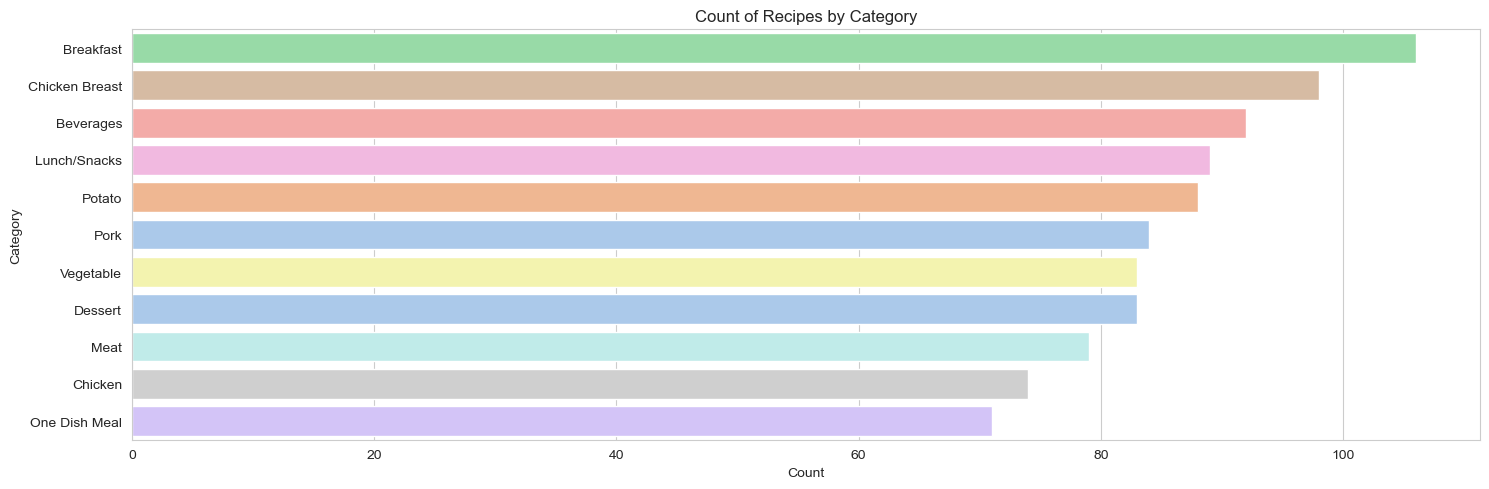

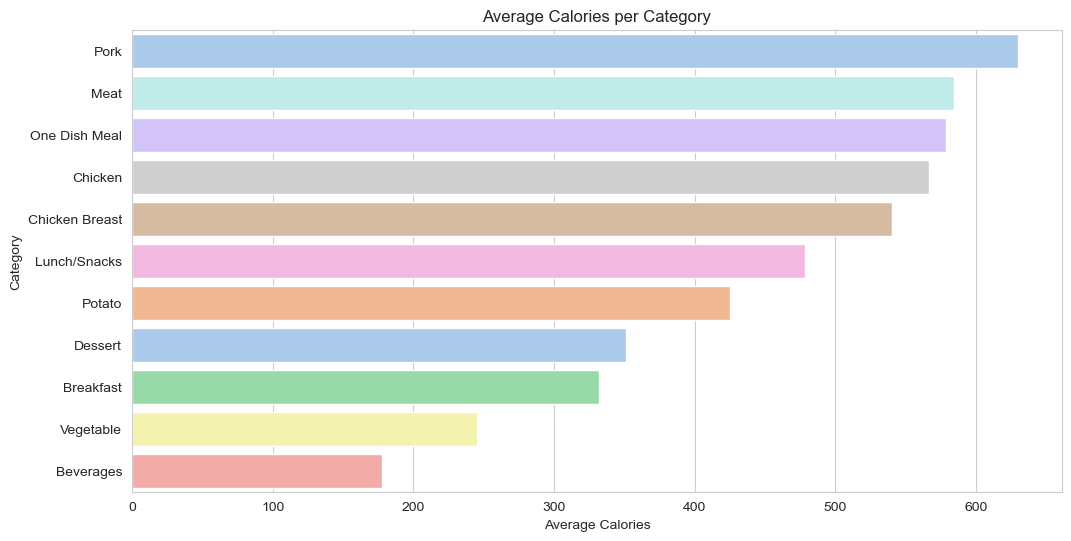

In [18]:
# Setting the visual style for seaborn plots
sns.set_style("whitegrid")

# Step 1: Creating a color palette for categories
# Ensuring that we have a unique color for each category
unique_categories = data['category'].unique()
palette = sns.color_palette('pastel', n_colors=len(unique_categories))

# Step 2: Assigning each category a color from the palette
# Ensuring that the color mapping is consistent with the categories in the DataFrame
color_mapping = {category: color for category, color in zip(unique_categories, palette)}

# Creating a bar chart showing the count of recipes by category
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(y='category', data=data, ax=ax, palette=color_mapping, order=data['category'].value_counts().index)
ax.set_title('Count of Recipes by Category')
ax.set_xlabel('Count')
ax.set_ylabel('Category')

# Adjusting layout for clear presentation
plt.tight_layout()
plt.show()

# Calculating the average calories per category
avg_calories = data.groupby('category')['calories'].mean().sort_values(ascending=False)

# Plotting the average calories per category in a bar chart
plt.figure(figsize=(12, 6))
# Ordering the bars from highest to lowest average calories
sns.barplot(y=avg_calories.index, x=avg_calories.values, data=data, errorbar=None, palette=color_mapping)
plt.title('Average Calories per Category')
plt.xlabel('Average Calories')
plt.ylabel('Category')

# Displaying the plot
plt.show()

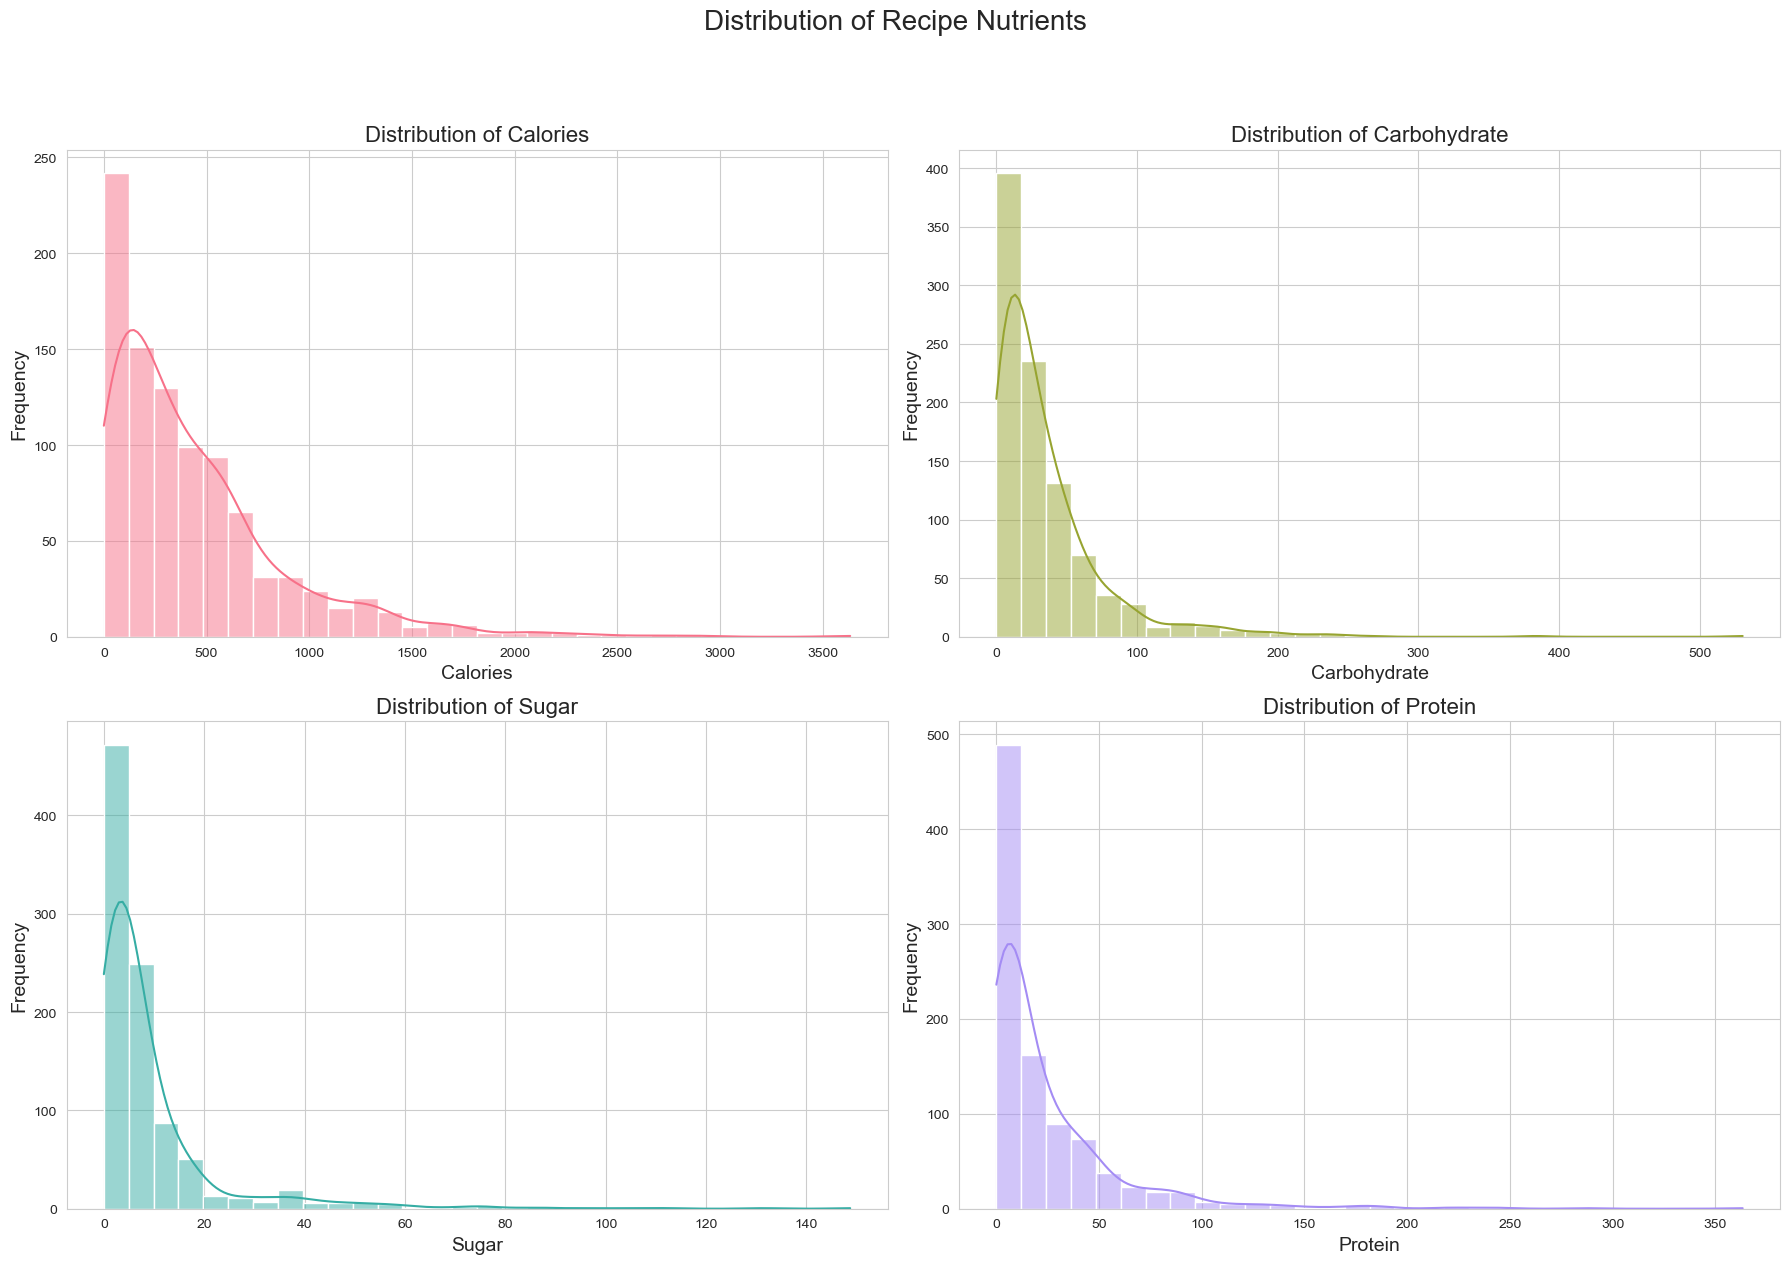

In [19]:
# Configuring the overall aesthetics for the histograms
sns.set_style("whitegrid")
nutrient_color_palette = sns.color_palette("husl", 4)  # "husl" provides a perceptually uniform color palette

# Initializing a 2x2 subplot structure for displaying histograms
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Distribution of Recipe Nutrients', fontsize=20, y=1.05)

# Listing the nutrient columns to be visualized in histograms
nutrients_to_plot = ['calories', 'carbohydrate', 'sugar', 'protein']

# Plotting histograms for each nutrient with Kernel Density Estimate (KDE)
for index, nutrient in enumerate(nutrients_to_plot):
    sns.histplot(data[nutrient], ax=axes[index // 2, index % 2], color=nutrient_color_palette[index], kde=True, bins=30)
    axes[index // 2, index % 2].set_title(f'Distribution of {nutrient.capitalize()}', fontsize=16)
    axes[index // 2, index % 2].set_ylabel('Frequency', fontsize=14)
    axes[index // 2, index % 2].set_xlabel(nutrient.capitalize(), fontsize=14)

# Adjusting the layout for a neat and clear presentation
plt.tight_layout()
plt.show()

## Outlier Detection Criteria

We posit that certain data entries may be implausible and thus be considered outliers. Specifically, we will investigate entries where the calorie count is lower than any other nutritional attributes like protein, carbohydrate, or sugar. Such conditions are typically indicative of data inconsistencies and warrant further scrutiny or correction.

In [20]:
def find_outlier_indices_by_calories(df):
    """
    Identify the indices of rows where the calorie count is implausibly lower than other nutritional values.
    
    Parameters:
    - df (pandas.DataFrame): The DataFrame containing nutritional information.
    
    Returns:
    - pandas.Index: Index objects containing the indices of the rows with implausible calorie values.
    """
    # Identifying indices where calorie count is less than the count of sugar, protein, or carbohydrate
    indices_with_lower_calories = df[
        (df['calories'] < df['sugar']) |
        (df['calories'] < df['protein']) |
        (df['calories'] < df['carbohydrate'])
    ].index

    return indices_with_lower_calories

In [21]:
# Utilizing the find_outlier_indices_by_calories function to detect outliers in the dataset
outlier_indices = find_outlier_indices_by_calories(data)

# Displaying the rows in the dataset that are flagged as outliers
outlier_rows = data.loc[outlier_indices]
outlier_rows

recipe  calories  carbohydrate   sugar  protein        category  \
1         2     35.48         38.56    0.66     0.92          Potato   
20       21      9.26         17.44    8.16    10.81          Potato   
21       22     40.53         87.91  104.91    11.93         Dessert   
29       30    164.76         33.58   17.87   220.14   One Dish Meal   
37       38     44.55         99.82    2.62    15.57       Breakfast   
..      ...       ...           ...     ...      ...             ...   
878     879     88.26         18.58    5.21    99.64            Meat   
886     887     30.37         38.40    0.10    35.20       Vegetable   
905     906     42.30         12.14    1.86    87.25  Chicken Breast   
922     923     27.65         31.14    3.60     8.66          Potato   
928     929      5.87         47.91   30.06    24.72            Meat   

     servings high_traffic  
1         4.0         High  
20        6.0         High  
21        4.0          Low  
29        2.0         High  
37        4.0          Low  
..        ...          ...  
878       6.0         High  
886       2.0         High  
905       2.0          Low  
922       4.0         High  
928       4.0         High  

[103 rows x 8 columns]

In [22]:
# Removing the outliers from the dataset based on the previously identified indices
# Resetting the index is important after row deletions to maintain DataFrame integrity
data_cleaned = data.drop(outlier_indices).reset_index(drop=True)

# The cleaned DataFrame without the outlier rows is now stored in data_cleaned
# This helps in maintaining a clear distinction between the original and cleaned data

In [23]:
data_cleaned.describe()

recipe     calories  carbohydrate       sugar     protein  \
count  844.000000   844.000000    844.000000  844.000000  844.000000   
mean   472.954976   487.454194     30.867808    8.652725   23.248709   
std    273.629093   444.066959     33.227413   13.034691   31.792876   
min      1.000000    15.790000      0.030000    0.010000    0.000000   
25%    237.750000   179.332500      8.402500    1.807500    3.467500   
50%    471.500000   367.610000     21.655000    4.825000   11.220000   
75%    708.250000   629.710000     41.620000    9.105000   31.582500   
max    947.000000  3633.160000    243.200000  131.390000  286.970000   

         servings  
count  844.000000  
mean     3.466825  
std      1.731733  
min      1.000000  
25%      2.000000  
50%      4.000000  
75%      4.000000  
max      6.000000

In [24]:
def detect_outliers_iqr(df, target_columns):
    """
    Detects outliers in the specified columns of a DataFrame using the IQR method.

    Args:
    - df (pandas.DataFrame): The DataFrame to analyze.
    - target_columns (list of str): The list of column names to check for outliers.

    Returns:
    - dict: A dictionary where keys are column names and values are DataFrames of the outliers.
    """
    outlier_dict = {}
    
    for column in target_columns:
        # Determine the first and third quartile
        Q1 = df[column].quantile(0.03)
        Q3 = df[column].quantile(0.97)
        IQR = Q3 - Q1

        # Establish boundaries for outliers beyond 1.5 times the IQR from the Q1 and Q3
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter outliers outside the interquartile range
        outlier_rows = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Collect outliers in a dictionary
        outlier_dict[column] = outlier_rows
    
    return outlier_dict

# List of numeric columns to check for outliers
numeric_cols = ['sugar', 'protein', 'carbohydrate', 'calories']

# Detecting outliers in the numeric columns of the DataFrame
detected_outliers = detect_outliers_iqr(data_cleaned, numeric_cols)

# Combining outliers from different columns into one DataFrame and removing duplicate entries
combined_outliers = pd.concat(detected_outliers.values()).drop_duplicates()

# Displaying the consolidated DataFrame of outliers
combined_outliers

recipe  calories  carbohydrate   sugar  protein        category  \
260     291    239.90         51.13  131.39     3.38         Dessert   
620     696    891.11         15.20    1.50   286.97         Chicken   
764     862   1646.67          9.42    5.12   245.57  Chicken Breast   

     servings high_traffic  
260       2.0         High  
620       2.0          Low  
764       6.0         High

In [25]:
# Removing the outlier entries from the cleaned DataFrame using the indices from the combined_outliers DataFrame
# It's crucial to reset the index to maintain DataFrame integrity after row deletions
data_without_outliers = data_cleaned.drop(combined_outliers.index).reset_index(drop=True)

# The resultant DataFrame is stored in data_without_outliers, excluding the detected outlier rows

In [26]:
data_without_outliers.describe()

recipe     calories  carbohydrate       sugar     protein  \
count  841.000000   841.000000    841.000000  841.000000  841.000000   
mean   472.443520   485.890202     30.887848    8.519489   22.694400   
std    273.607743   442.753447     33.266725   12.348383   29.529335   
min      1.000000    15.790000      0.030000    0.010000    0.000000   
25%    237.000000   178.980000      8.320000    1.810000    3.470000   
50%    471.000000   367.300000     21.670000    4.820000   11.200000   
75%    708.000000   629.710000     41.600000    9.100000   31.570000   
max    947.000000  3633.160000    243.200000   95.750000  221.910000   

         servings  
count  841.000000  
mean     3.467301  
std      1.731140  
min      1.000000  
25%      2.000000  
50%      4.000000  
75%      4.000000  
max      6.000000

In [27]:
# Constructing an interactive 3D scatter plot to visualize the nutritional content and traffic level
# Plotly Express is used for its interactive capabilities and ease of use
plot_figure = px.scatter_3d(
    data_without_outliers,  # Using the dataset with outliers removed for accuracy
    x='protein',
    y='carbohydrate',
    z='calories',
    color='high_traffic',
    size='sugar',
    hover_data=['category'],
    color_discrete_map={"High": "gold", "Low": "blue"},  # Assigning colors to represent traffic levels
    labels={'calories': 'Calories', 'carbohydrate': 'Carbohydrates', 'protein': 'Protein', 'sugar': 'Sugar'},
    title="3D Scatter Plot of Nutritional Content by Traffic Level"
)

# Displaying the interactive plot
plot_figure.show()

In [28]:
# Generating an interactive bubble chart to explore the relationship between calories and protein
# The size of the bubbles represents the sugar content, providing an additional layer of insight
interactive_bubble_chart = px.scatter(
    data_without_outliers,  # Using the cleaned data for accurate representation
    x='calories',
    y='protein',
    size='sugar',
    color='high_traffic',
    hover_data=['category'],
    color_discrete_map={"High": "gold", "Low": "blue"},  # Color coding for high and low traffic
    labels={'calories': 'Calories', 'protein': 'Protein', 'sugar': 'Sugar'},
    title="Bubble Chart: Calories vs. Protein, sized by Sugar Content",
    size_max=60  # Maximizing bubble size for better visualization
)

# Displaying the bubble chart for interactive analysis
interactive_bubble_chart.show()

# Feature Engineering Section

In this section, we will embark on feature engineering, a crucial step in preparing our dataset for machine learning models. Feature engineering involves creating new features or modifying existing ones to enhance model performance and uncover more insights from the data.

## Rationale for 'Sugar to Calories' Feature

The creation of a new feature, `sugar_to_calories`, is a strategic step in enriching our dataset. This feature quantifies the relative sugar content per calorie in each recipe, offering a critical insight into the nutritional composition. In an era where health and dietary awareness is paramount, the sugar concentration in foods carries significant importance. 

A higher sugar-to-calorie ratio might be indicative of dessert-like or indulgent recipes, while a lower ratio could suggest more nutritionally balanced options. This metric is expected to provide valuable insights into health-related aspects of recipes, which may influence their popularity or web traffic. By incorporating this feature, we aim to uncover patterns in user preferences and recipe selection, adding a layer of depth to our analysis and enhancing the potential for meaningful insights.

In [29]:
# Creating a new feature 'sugar_to_calories' to measure the proportion of sugar per calorie
# This feature will provide insights into the nutritional balance of the recipes
data_without_outliers['sugar_to_calories'] = data_without_outliers['sugar'] / data_without_outliers['calories']

# Ensuring that the operation does not produce infinite or NaN values due to division by zero
data_without_outliers['sugar_to_calories'].replace([np.inf, -np.inf], np.nan, inplace=True)

## Utilizing Pearson Correlation Heatmaps Pre- and Post-Transformation

We will apply Pearson correlation coefficient heatmaps to the numeric features of our dataset, both before and after data transformations. This dual approach allows us to effectively gauge the impact of our transformations on the linear relationships between variables. Such an analysis is particularly pivotal in cases where the heatmap insights contribute to feature selection or in understanding multicollinearity in preparation for linear modeling. The post-transformation heatmap is especially crucial as it reflects the data in the form that will be presented to the model, thereby ensuring more accurate and relevant insights for model building.

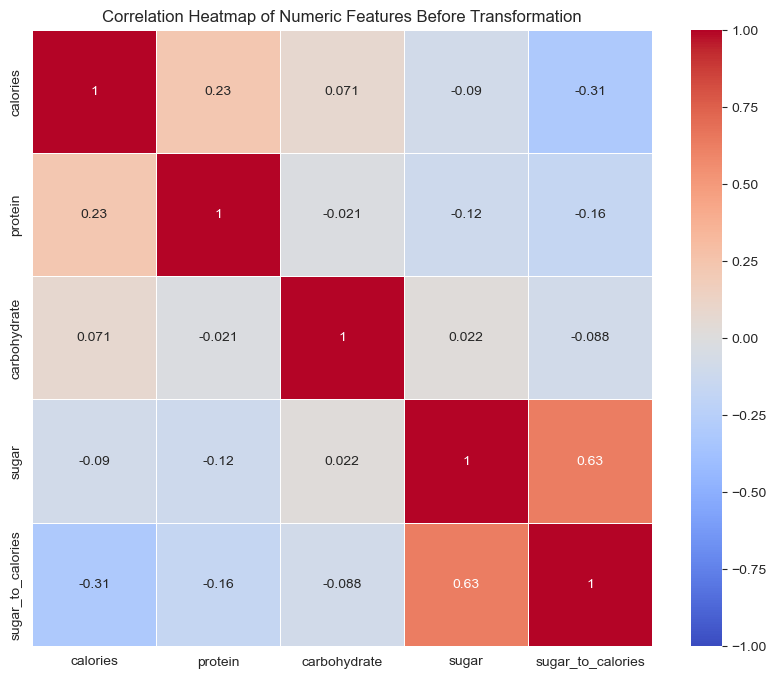

In [30]:
# Calculating the correlation matrix for numeric columns in the pre-transformed dataset
numeric_features = ['calories', 'protein', 'carbohydrate', 'sugar', 'sugar_to_calories']  # Specify numeric features
correlation_matrix_before_transformation = data_without_outliers[numeric_features].corr()

# Creating a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_before_transformation, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Adding title and displaying the heatmap
plt.title('Correlation Heatmap of Numeric Features Before Transformation')
plt.show()

## Applying the Box-Cox Transformation

The Box-Cox transformation will be employed to achieve two primary objectives:
1. **Variance Stabilization**: The transformation is aimed at stabilizing the variance across the dataset, which is a common prerequisite for many statistical models.
2. **Gaussian-like Distribution**: It helps in transforming the data to resemble a Gaussian distribution more closely, which aligns with the assumptions of numerous statistical techniques.

This transformation is particularly vital for linear modeling, as these models often presuppose constant variance and normal distribution of data. By applying Box-Cox, we aim to rectify issues of non-linearity and heteroskedasticity (variance instability) in specific columns. This ensures that our data conforms more accurately to the assumptions underpinning our analytical and modeling approaches.

In [31]:
# Identifying columns to undergo Box-Cox transformation
columns_for_transformation = ['calories', 'carbohydrate', 'sugar', 'protein', 'sugar_to_calories']

# Initializing a dictionary to keep track of lambda values used in Box-Cox transformation
boxcox_lambdas = {}

for column in columns_for_transformation:
    # Ensuring all values are positive before applying Box-Cox
    if data_without_outliers[column].min() <= 0:
        data_without_outliers[column] += abs(data_without_outliers[column].min()) + 1
    
    # Applying the Box-Cox transformation to the column
    transformed_data, lambda_value = boxcox(data_without_outliers[column])
    data_without_outliers[column] = transformed_data
    
    # Storing the lambda value for future reference
    boxcox_lambdas[column] = lambda_value

# Displaying the lambda values used for each transformed column
boxcox_lambdas

{'calories': 0.17605699734046656,
 'carbohydrate': 0.23943232860889346,
 'sugar': 0.12175620610686429,
 'protein': 0.051918705190650206,
 'sugar_to_calories': 0.030387647419414583}

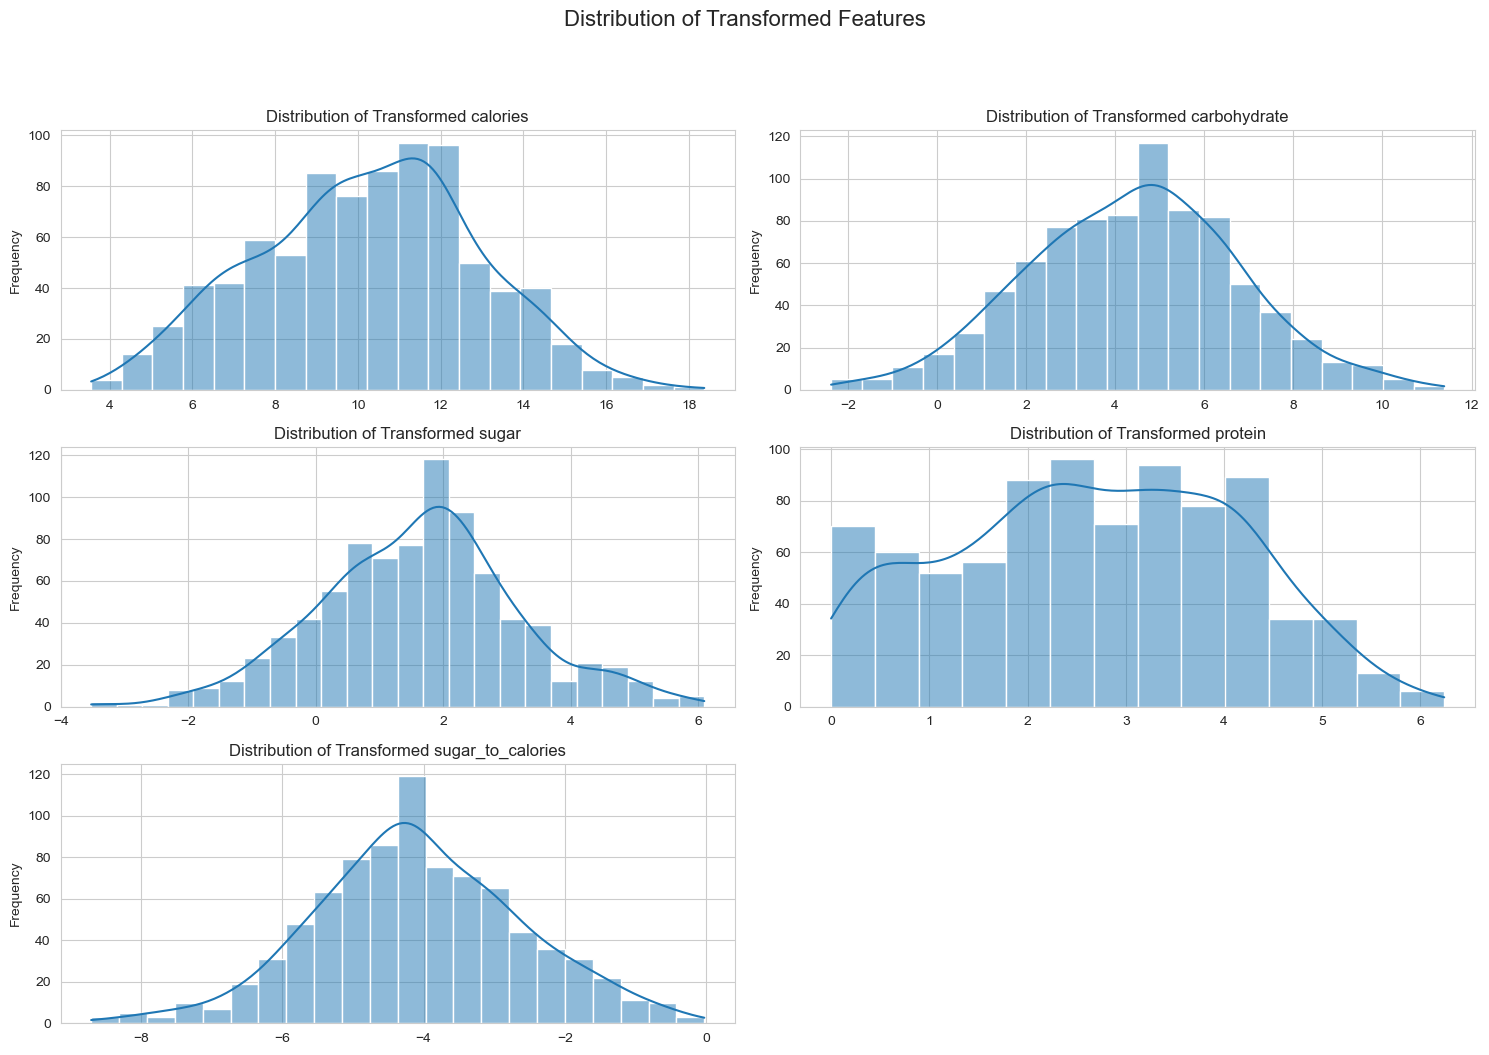

In [32]:
# Configuring the visual style for the histograms
sns.set_style("whitegrid")

# Initializing a subplot grid for the transformed feature distributions
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Distribution of Transformed Features', fontsize=16, y=1.05)

# Visualizing histograms for each transformed feature
for index, feature in enumerate(columns_for_transformation):
    sns.histplot(data=data_without_outliers, x=feature, kde=True, ax=axes[index // 2, index % 2])
    axes[index // 2, index % 2].set_title(f'Distribution of Transformed {feature}')
    axes[index // 2, index % 2].set_ylabel('Frequency')
    axes[index // 2, index % 2].set_xlabel('')

# Disabling the unused subplot in the grid
axes[2, 1].axis('off')

# Adjusting the layout for a clear and neat display
plt.tight_layout()
plt.show()

## Utilizing Mahalanobis Distance for Outlier Detection

We will employ the Mahalanobis Distance method for its distinct advantages in outlier detection:
1. **Scale-Invariance**: This method inherently accounts for the variance in each feature, obviating the need for prior normalization.
2. **Correlation Consideration**: By factoring in the interrelationships among features, Mahalanobis Distance captures the true structure of the data more effectively.
3. **Multivariate Analysis Capability**: It assesses outliers based on a collective analysis of all features, providing a more comprehensive approach.
4. **Robustness**: The method is well-suited to handle diverse scales of features, ensuring a consistent and reliable identification of outliers.

Mahalanobis Distance's unique ability to integrate these aspects makes it a powerful tool for outlier detection in a multivariate context.

In [33]:
def calculate_mahalanobis_distance(dataset):
    """
    Calculates the Mahalanobis Distance for each observation in the dataset.

    Args:
    - dataset (pandas.DataFrame or numpy.ndarray): Numeric dataset to compute distances for

    Returns:
    - List[float]: A list of computed Mahalanobis distances for each observation in the dataset
    """
    
    # Converting DataFrame to numpy array if it's not already
    data_array = dataset.values if isinstance(dataset, pd.DataFrame) else dataset

    # Computing the inverse of the covariance matrix
    covariance_matrix = np.cov(data_array, rowvar=False)
    inverse_covariance_matrix = np.linalg.inv(covariance_matrix)

    # Calculating the mean values for each feature
    mean_values = np.mean(data_array, axis=0)

    # Computing Mahalanobis distance for each observation
    mahalanobis_distances = [distance.mahalanobis(observation, mean_values, inverse_covariance_matrix) for observation in data_array]

    return mahalanobis_distances

In [34]:
# Selecting numeric columns for Mahalanobis distance computation
numeric_columns = ['calories', 'carbohydrate', 'sugar', 'protein']
numeric_data_for_analysis = data_without_outliers[numeric_columns]

# Calculating Mahalanobis distances for the selected numeric data
calculated_distances = calculate_mahalanobis_distance(numeric_data_for_analysis)

# Determining the threshold for outliers (99.5th percentile as a cutoff)
outlier_detection_threshold = np.percentile(calculated_distances, 99.5)

# Identifying rows that exceed the outlier threshold
outlier_indices = np.where(np.array(calculated_distances) > outlier_detection_threshold)[0]
total_outliers = len(outlier_indices)

# Printing the number of outliers detected
print(f"Number of outliers identified: {total_outliers}")

Number of outliers identified: 5


In [35]:
# Displaying the rows in the dataset that are flagged as outliers based on the Mahalanobis distance
outlier_data = data_without_outliers.loc[outlier_indices]

# Showing the outlier observations for further analysis or review
outlier_data

recipe   calories  carbohydrate     sugar   protein       category  \
16       18  15.353040     -1.770051 -0.889637  3.875797           Meat   
164     186  14.300098      9.777555 -0.511042  0.382179   Lunch/Snacks   
618     695  14.521037      9.735313 -1.693955  1.312550  One Dish Meal   
750     848   6.817835      6.447429 -3.525038  0.339428      Beverages   
820     926  18.372493      5.182106 -0.985496  1.238133        Chicken   

     servings high_traffic  sugar_to_calories  
16        1.0         High          -7.396192  
164       4.0         High          -6.843202  
618       2.0         High          -7.953059  
750       6.0          Low          -7.938375  
820       4.0          Low          -8.061933

## Pearson Correlation Heatmap Post-Transformation

Following the transformation of numeric features, we will now reassess the relationships between these variables using a Pearson correlation coefficient heatmap. This analysis is crucial to observe any changes in the linear relationships due to the transformations applied and to understand the impact on feature interdependencies. This step is particularly important for informed feature selection and model optimization.

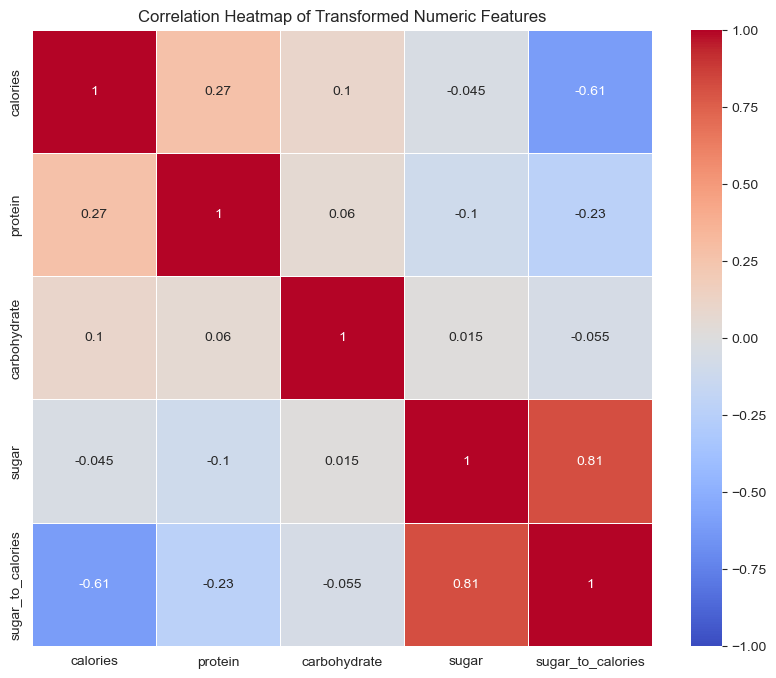

In [36]:
# Calculating the correlation matrix for the transformed numeric columns in the dataset
transformed_numeric_features = ['calories', 'protein', 'carbohydrate', 'sugar', 'sugar_to_calories']  # Specify transformed numeric features
correlation_matrix_after_transformation = data_without_outliers[transformed_numeric_features].corr()

# Creating a heatmap to visualize the correlation matrix post-transformation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_after_transformation, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

# Adding title and displaying the heatmap
plt.title('Correlation Heatmap of Transformed Numeric Features')
plt.show()

## Analysis of Correlation Changes Post-Transformation

Upon comparing the correlation heatmaps before and after the data transformations, several key observations emerge:

1. **Correlation Shift in First and Second Variables**: Post-transformation, there's a slight decrease in the correlation, moving from 0.00627249 to 0.0007567.
2. **Significant Change Between Second and Seventh Variables**: The correlation here has notably shifted from -0.07620034 to -0.675793389, indicating a marked change in their relationship.
3. **Increased Correlation Between Fourth and Seventh Variables**: A significant increase in correlation is observed, from 0.13112535 to 0.737715044, suggesting a stronger linear relationship post-transformation.

These observations highlight that the transformations applied have notably impacted the linear relationships between certain pairs of variables, altering the dataset's overall correlation structure.

## Implementing Categorical Binning for Discretization

In this stage of our data processing, we will be applying **categorical binning** or **discretization**. This technique is employed to convert continuous variables into categorical formats. The primary advantages of discretization include:

- **Enhanced Interpretability**: Transforming numerical data into categories can simplify the understanding and communication of data patterns.
- **Analysis Ease**: Categorical variables are often easier to analyze, especially in certain types of statistical or machine learning models.

The aim is to make continuous data more manageable and insightful, particularly when categorical relationships are more relevant to our analysis or modeling objectives.

In [37]:
def bin_continuous_variable_into_three(col):
    """
    Bins a continuous variable into three categories: 'Low', 'Medium', 'High'.

    Args:
    - col (pandas.Series): A continuous variable from a DataFrame.

    Returns:
    - List[str]: A list of binned category labels corresponding to each entry in the input column.
    """
    # Calculating the first and third quantile to determine binning thresholds
    first_quantile, third_quantile = col.quantile([0.33, 0.66])

    # Assigning each value to a bin based on its position relative to the quantiles
    binned_values = ['Low' if value <= first_quantile else 'Medium' if value <= third_quantile else 'High' for value in col]
    return binned_values

In [38]:
# Applying the binning function to transform continuous variables into categorical bins
continuous_features = ['sugar', 'protein', 'carbohydrate', 'calories']
for feature in continuous_features:
    # Creating new columns for binned data, with '_3_bin' suffix indicating the categorization into three bins
    data_without_outliers[feature + '_3_bin'] = bin_continuous_variable_into_three(data_without_outliers[feature])

# This process results in new columns in the DataFrame, offering a categorical perspective of these continuous variables

# Model Development Section

This section is dedicated to the development of predictive models. Key considerations in structuring the code for this section include:
- **Modularity**: By designing the code with modularity in mind, we enhance its reusability and maintainability. This approach allows for easy adaptation and extension in various modeling scenarios.
- **Facilitated Experimentation**: The code is crafted to streamline the process of experimenting with different modeling algorithms. This flexibility is crucial for evaluating the performance of various models and selecting the most effective approach for our dataset.

The goal is to create a robust and adaptable framework that can accommodate a diverse range of machine learning models, thereby enabling comprehensive analysis and prediction.

## Custom Functions for Model Development

In preparation for the model development phase, we will define a set of custom functions. These functions are designed to streamline various tasks within the modeling workflow, including data preprocessing, model training, evaluation, and visualization. The creation of these custom functions aims to enhance the efficiency and modularity of our modeling process, allowing for more systematic and reproducible results.

In [39]:
def prepare_dataset_for_modeling(dataset, target_column, columns_to_drop=[], test_split_size=0.2, random_seed=42):
    """
    Prepares the dataset for modeling by encoding categorical variables and splitting into train and test sets.

    Args:
    - dataset (pandas.DataFrame): The DataFrame containing the dataset.
    - target_column (str): The name of the target variable column.
    - columns_to_drop (list of str, optional): List of columns to drop from the dataset. Default is an empty list.
    - test_split_size (float, optional): Fraction of the dataset to include in the test split. Default is 0.2.
    - random_seed (int, optional): Seed for random number generation for reproducibility. Default is 42.

    Returns:
    - tuple: Contains the training and testing datasets (X_train, X_test, y_train, y_test) and a dictionary of label encoders.
    """
    
    # Encoding categorical variables using Label Encoder
    label_encoders_dict = {}
    for column_name in dataset.select_dtypes(include=['object']).columns:
        encoder = LabelEncoder()
        dataset[column_name] = encoder.fit_transform(dataset[column_name])
        label_encoders_dict[column_name] = encoder

    # Separating features and target variable
    features = dataset.drop(columns=columns_to_drop)
    target = dataset[target_column]

    # Splitting the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_split_size, 
                                                        random_state=random_seed, stratify=target)
    
    return X_train, X_test, y_train, y_test, label_encoders_dict

In [40]:
def fit_model_to_training_data(machine_learning_model, training_features, training_target):
    """
    Fits a specified machine learning model to the training data.

    Args:
    - machine_learning_model (model object): The machine learning model that needs to be trained.
    - training_features (pandas.DataFrame): DataFrame containing the features of the training data.
    - training_target (pandas.Series): Series containing the target variable of the training data.

    Returns:
    - model object: The machine learning model trained on the given data.
    """
    
    # Training the model on the provided training dataset
    machine_learning_model.fit(training_features, training_target)

    # Returning the trained model
    return machine_learning_model

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, classification_report

def assess_model_performance(trained_model, test_features, test_target, is_binary_classification=True):
    """
    Assesses the performance of a trained machine learning model on test data using various metrics.

    Args:
    - trained_model (model object): The machine learning model to be evaluated.
    - test_features (pandas.DataFrame): Features of the test data.
    - test_target (pandas.Series): Target variable of the test data.
    - is_binary_classification (bool, optional): Indicates if the task is binary classification. Default is True.

    Returns:
    - dict: A dictionary containing various evaluation metrics.
    """
    # Predictions on the test set
    predicted_values = trained_model.predict(test_features)
    
    # Probabilities for ROC AUC and Log Loss, if applicable
    predicted_probabilities = trained_model.predict_proba(test_features)[:, 1] if hasattr(trained_model, 'predict_proba') else None
    
    # Compilation of evaluation metrics
    evaluation_metrics = {
        'Accuracy': accuracy_score(test_target, predicted_values),
        'Precision': precision_score(test_target, predicted_values, average='weighted', zero_division=0),
        'Recall': recall_score(test_target, predicted_values, average='weighted', zero_division=0),
        'F1 Score': f1_score(test_target, predicted_values, average='weighted'),
        'Log Loss': log_loss(test_target, predicted_probabilities) if predicted_probabilities is not None else None,
        'Classification Report': classification_report(test_target, predicted_values, zero_division=0, output_dict=True)
    }
    
    # Additional metrics for binary classification
    if is_binary_classification and predicted_probabilities is not None:
        evaluation_metrics['ROC AUC'] = roc_auc_score(test_target, predicted_probabilities)
        false_positive_rate, true_positive_rate, _ = roc_curve(test_target, predicted_probabilities)
        evaluation_metrics['fpr'] = false_positive_rate
        evaluation_metrics['tpr'] = true_positive_rate
    
    return evaluation_metrics

In [42]:
def display_model_performance_metrics(model_performance_metrics):
    """
    Displays visualizations for the performance metrics of machine learning models.

    Args:
    - model_performance_metrics (dict): A dictionary with model names as keys and their performance metrics as values.
    """
    
    # Configuring the plot style
    sns.set_style("whitegrid")
    
    # Metrics to be visualized in bar charts
    standard_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Log Loss']
    
    # Extracting model names
    models = list(model_performance_metrics.keys())
    
    # Visualizing standard metrics in bar charts
    for metric in standard_metrics:
        plt.figure(figsize=(12, 7))
        metric_values = [metrics[metric] for metrics in model_performance_metrics.values()]
        bars = plt.bar(models, metric_values, color=sns.color_palette('pastel', len(models)))
        
        for bar in bars:
            bar_height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, bar_height + 0.005, round(bar_height, 4), 
                     ha='center', va='bottom', color='black', weight='bold')
        
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.title(f'Model {metric} Comparison', fontsize=16)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # Visualizing ROC Curves
    plt.figure(figsize=(12, 7))
    for idx, (model, metrics) in enumerate(model_performance_metrics.items()):
        if 'fpr' in metrics and 'tpr' in metrics:
            plt.plot(metrics['fpr'], metrics['tpr'], color=sns.color_palette('husl', len(models))[idx], lw=2, 
                     label=f'{model} (AUC = {metrics["ROC AUC"]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Visualization of Classification Reports as Heatmaps
    for model, metrics in model_performance_metrics.items():
        if 'Classification Report' in metrics:
            report_df = pd.DataFrame(metrics['Classification Report']).transpose().drop(['support'], axis=1)
            plt.figure(figsize=(10, 6))
            sns.heatmap(report_df, annot=True, cmap="YlGnBu", cbar=False, fmt=".2f")
            plt.title(f'Classification Report for {model}', fontsize=16)
            plt.show()

## Model Training and Evaluation Process

This section marks the beginning of our journey into model training and evaluation. Here, we will apply the previously defined functions to train various machine learning models and assess their performance. The process involves:

- **Model Training**: Utilizing the `fit_model_to_training_data` function to train different models on our dataset.
- **Performance Evaluation**: Employing the `assess_model_performance` function to evaluate each model's effectiveness using a range of metrics.
- **Result Visualization**: Using the `display_model_performance_metrics` function to visually compare the performance of all models.

This systematic approach allows us to methodically examine and compare the strengths and weaknesses of each model, guiding our decision-making for the most suitable model selection.

## Preparing Data for Model Training

Prior to training our models, we will split our dataset into training and testing subsets. This step is fundamental in machine learning to evaluate the performance of models on unseen data. The split will be conducted while excluding the target variable and specific columns like 'recipe' that are not relevant for model training. This separation ensures that our models are trained on a representative sample of data and then tested on distinct data to gauge their generalization capability.

In [43]:
# Applying the prepare_dataset_for_modeling function to split the dataset
# The 'high_traffic' column is used as the target variable, and the 'recipe' column is excluded from the features
train_features, test_features, train_target, test_target, categorical_encoders = prepare_dataset_for_modeling(
    data_without_outliers, target_column='high_traffic', columns_to_drop=['high_traffic', 'recipe']
)

# Displaying the shapes of the training and testing datasets
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((672, 11), (169, 11), (672,), (169,))

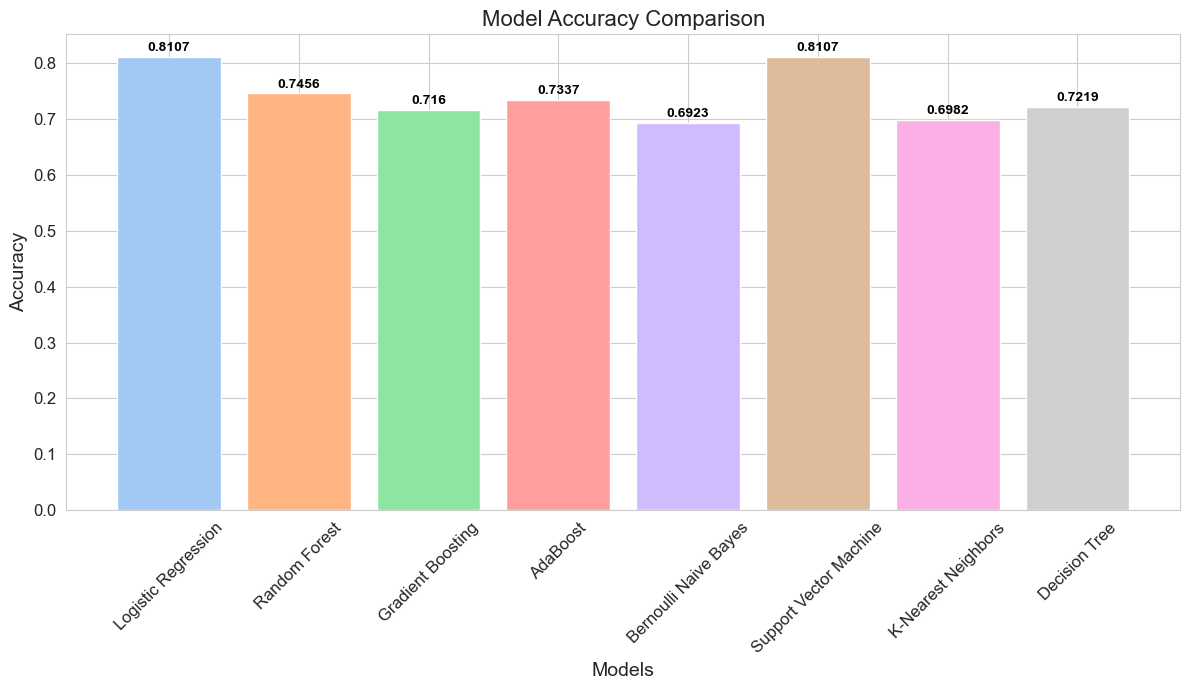

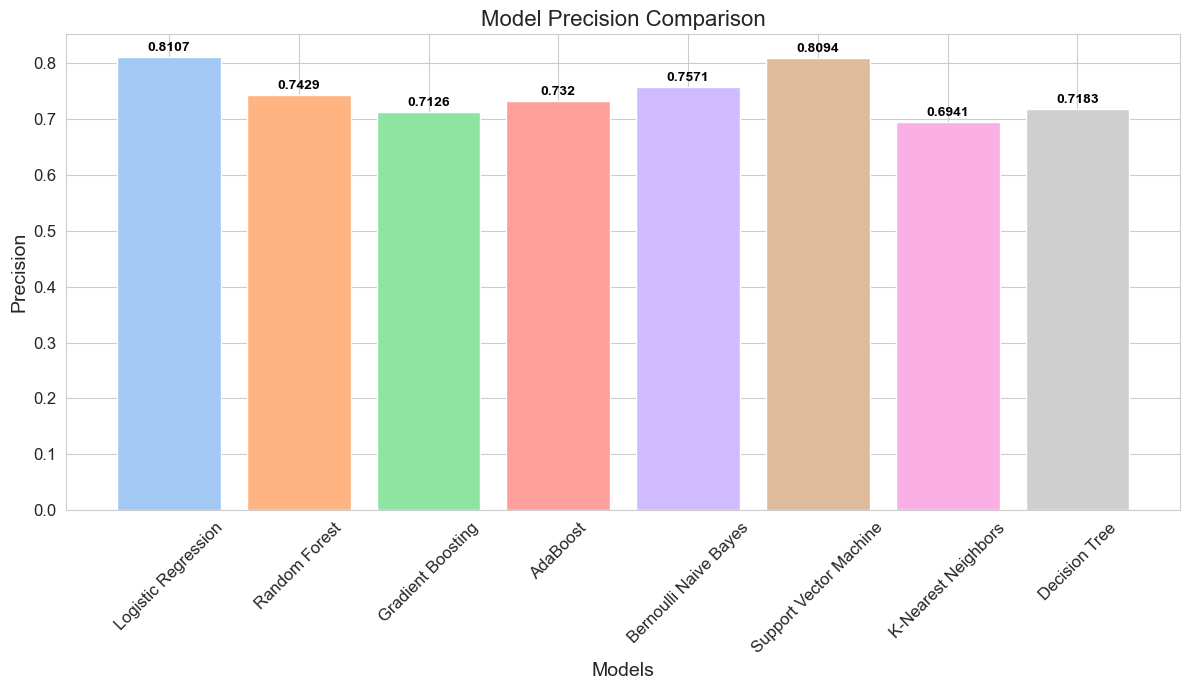

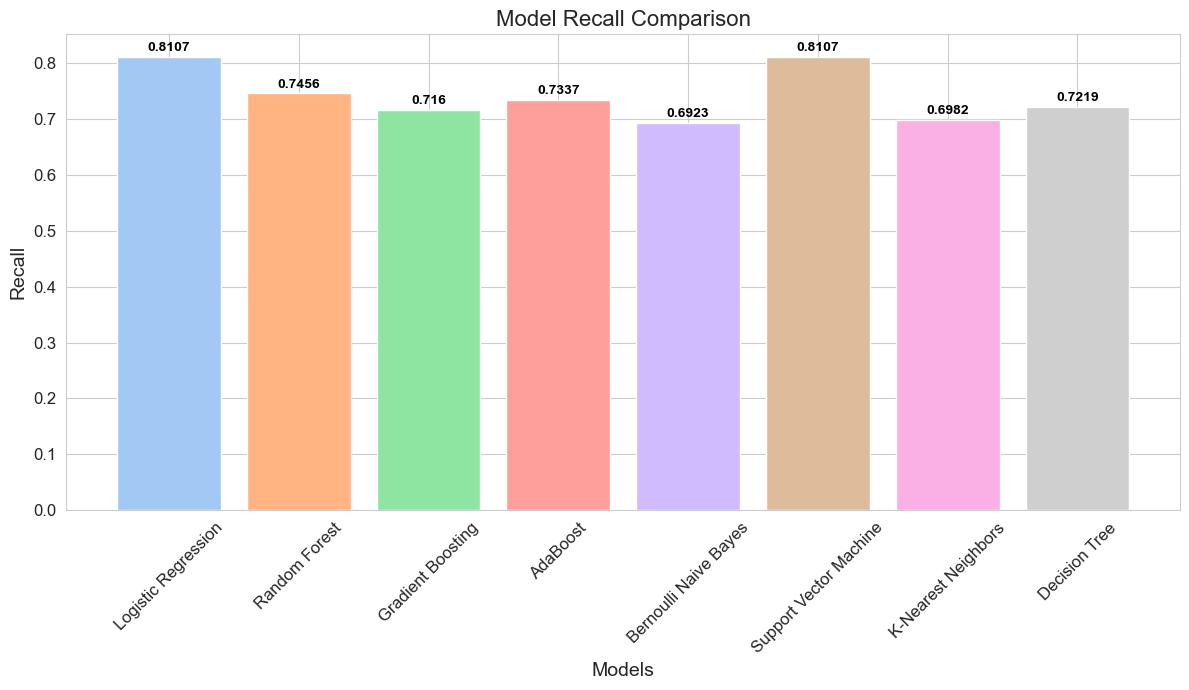

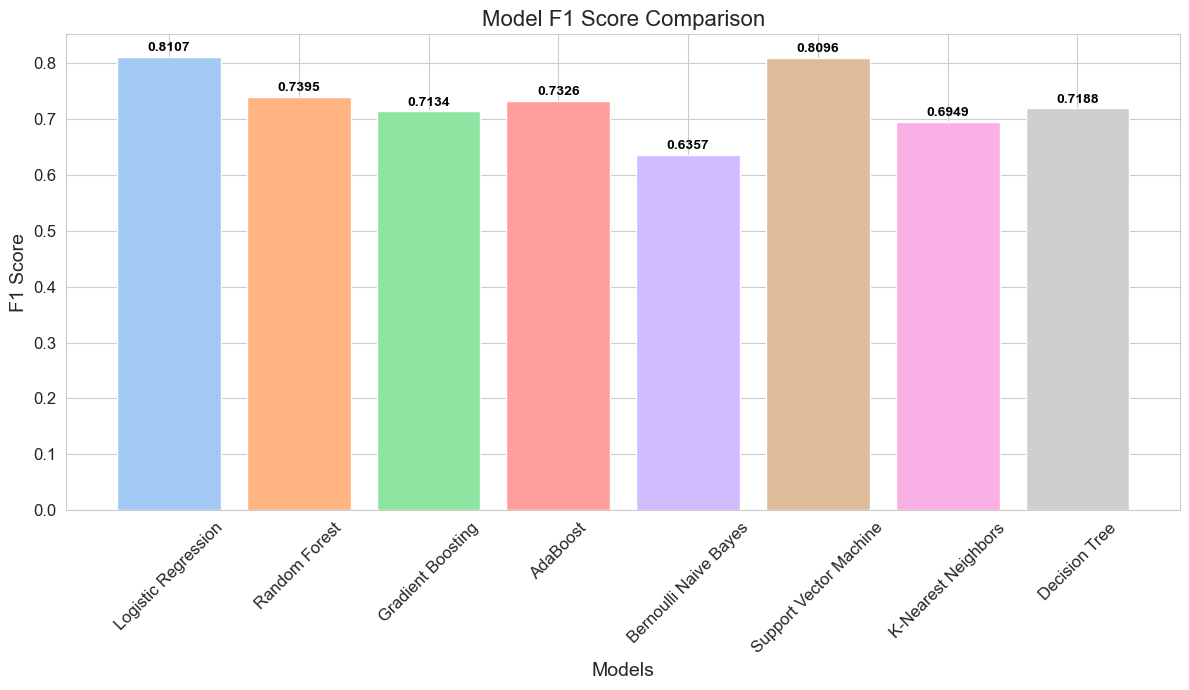

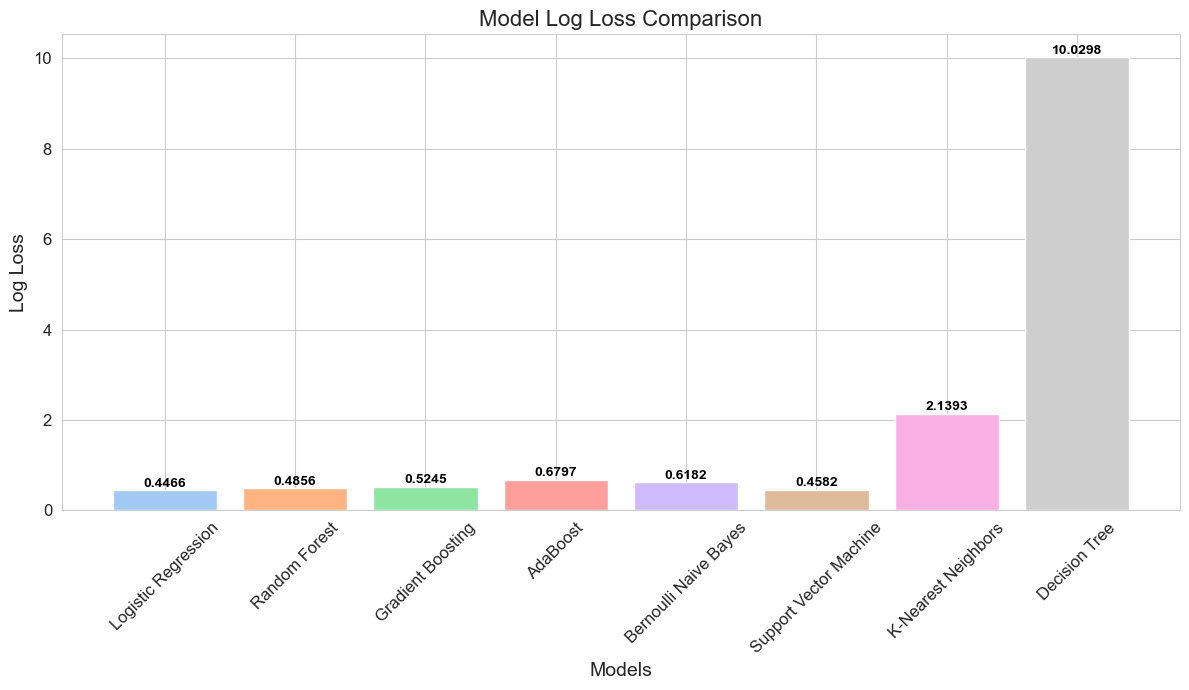

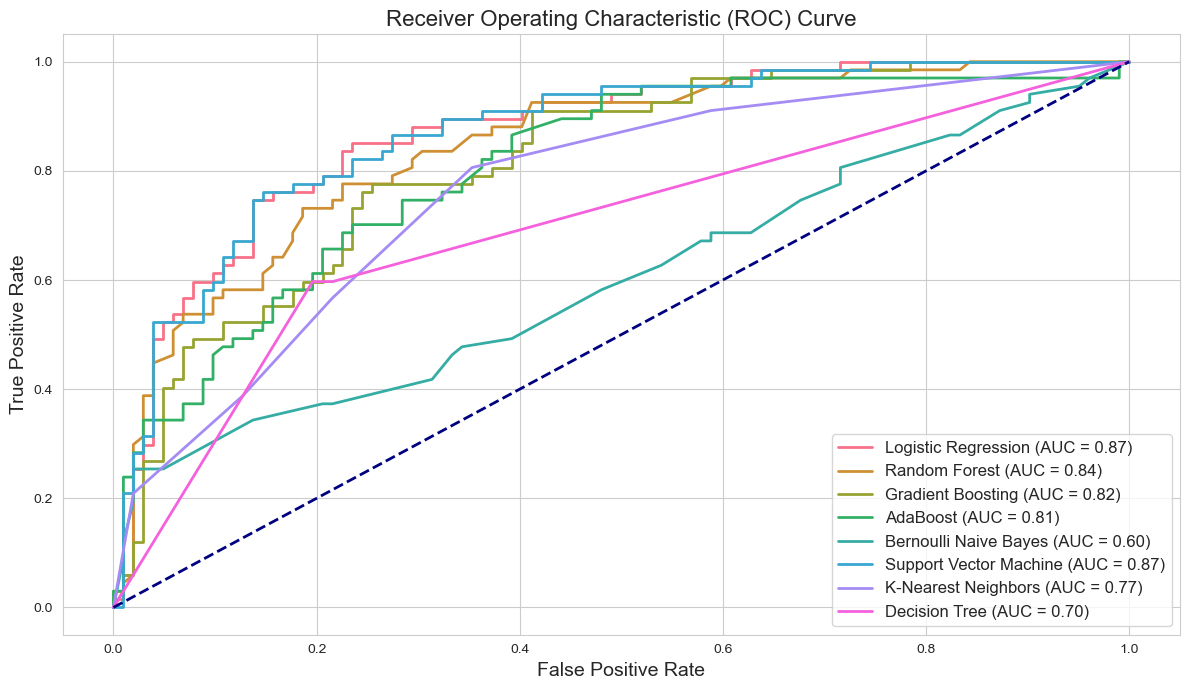

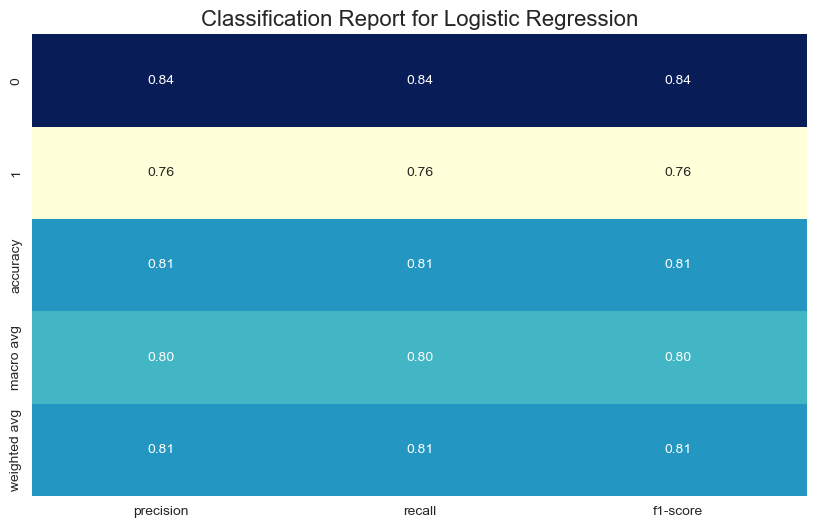

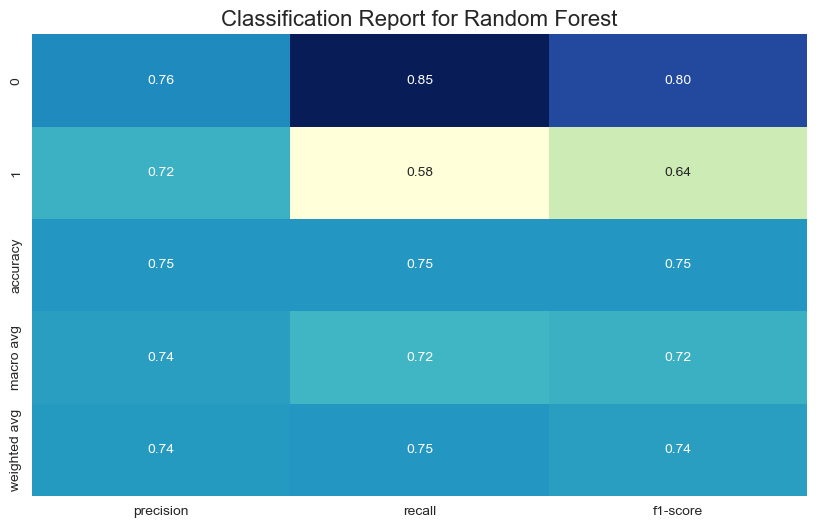

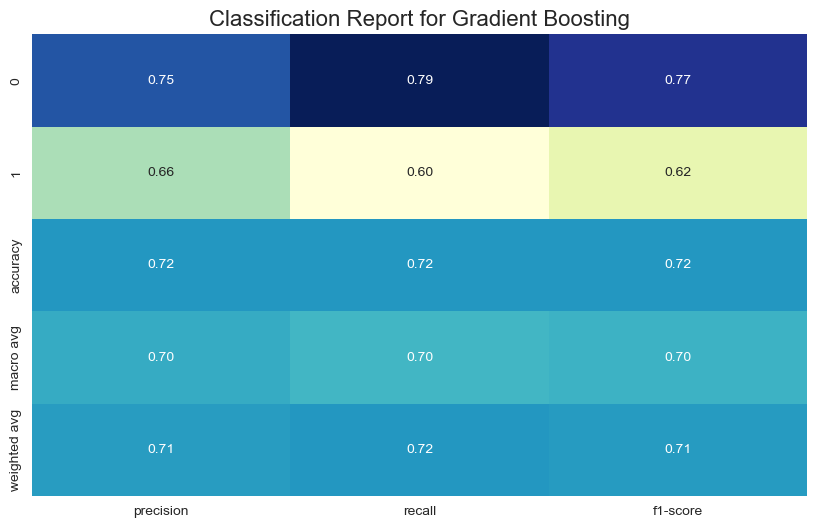

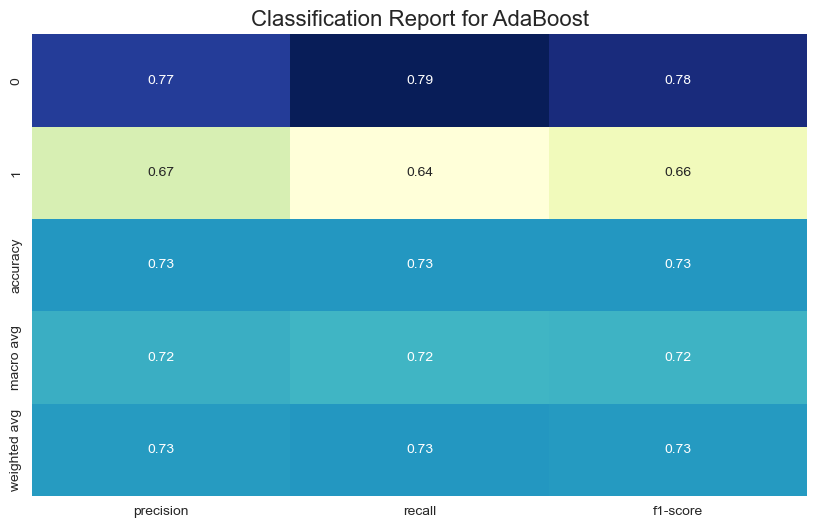

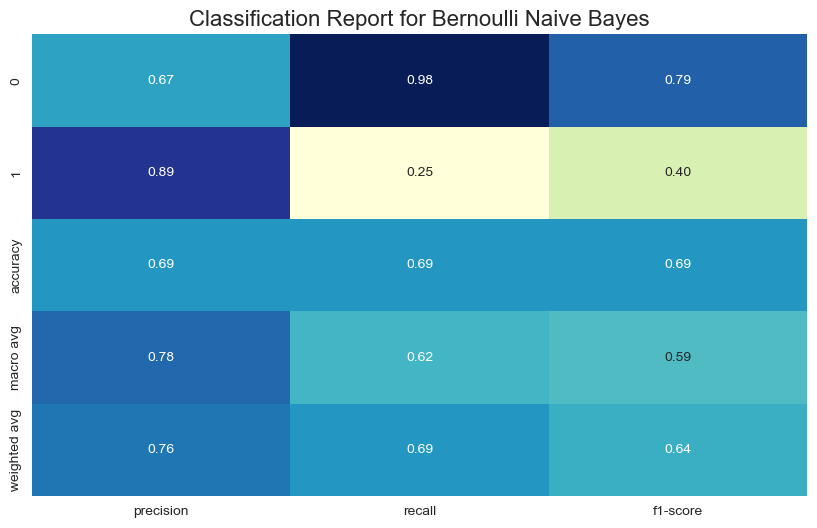

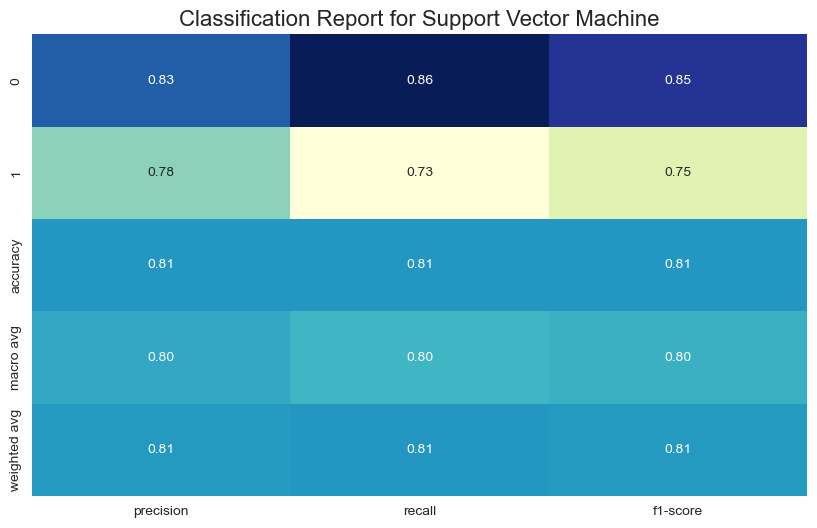

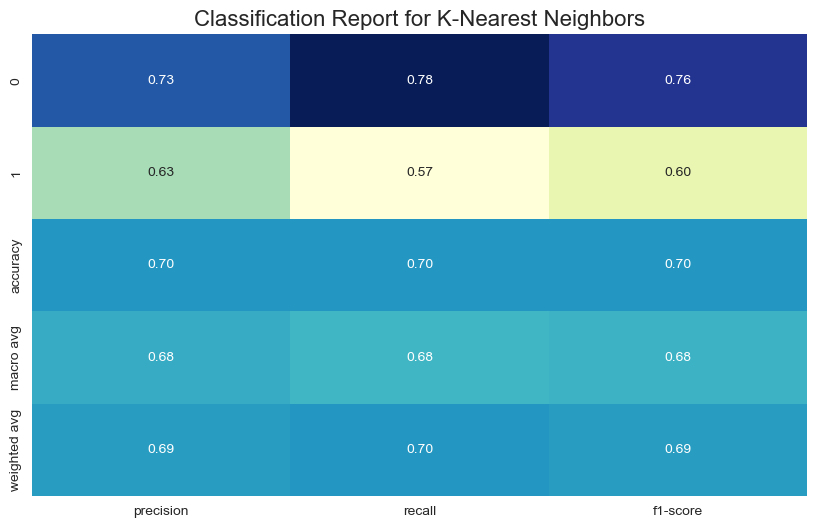

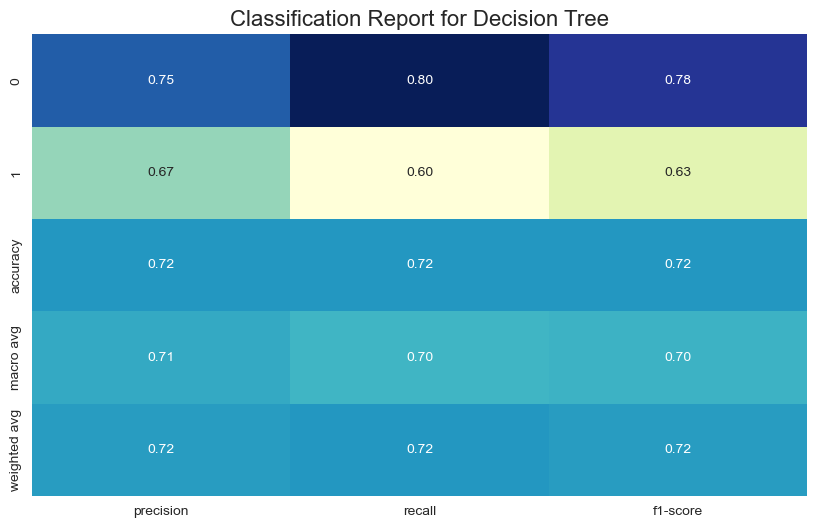

In [44]:
# Defining a variety of machine learning models for comparison
model_definitions = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Training each model using the training dataset
trained_models = {model_name: fit_model_to_training_data(model, train_features, train_target) for model_name, model in model_definitions.items()}

# Evaluating the performance of each trained model using the test dataset
model_performance_metrics = {model_name: assess_model_performance(model, test_features, test_target) for model_name, model in trained_models.items()}
model_accuracies = {model_name: metrics['Accuracy'] for model_name, metrics in model_performance_metrics.items()}

# Visualizing the performance metrics of the models
display_model_performance_metrics(model_performance_metrics)

## Analysis of Feature Importance in Machine Learning Models

This section is dedicated to evaluating the feature importance across different machine learning models. Understanding feature importance is crucial as it provides insights into the following aspects:
- **Model Interpretability**: Knowing which features significantly influence the model's predictions enhances our understanding of the model's decision-making process.
- **Data Insights**: Identifying key features can reveal underlying patterns and relationships within the data, offering valuable insights for further analysis.
- **Model Refinement**: Recognizing the most impactful features can guide subsequent model tuning and optimization efforts.

We will employ appropriate methods for each model to extract and analyze the significance of different features in influencing the model's predictions.

In [45]:
from sklearn.inspection import permutation_importance

def calculate_feature_importances(trained_models, training_features, training_labels):
    """
    Calculates the feature importances for each model in the given set of trained models.

    Args:
    - trained_models (dict): A dictionary of trained model objects.
    - training_features (pandas.DataFrame): The DataFrame containing features of the training data.
    - training_labels (pandas.Series): The Series containing the target labels of the training data.

    Returns:
    - dict: A dictionary with each model's name as keys and their feature importances as values.
    """
    importances = {}
    
    for model_name, model in trained_models.items():
        if hasattr(model, "feature_importances_"):
            # Directly use built-in feature importances for models that support it
            importances[model_name] = model.feature_importances_
        else:
            # For models without built-in feature importances, use permutation importance
            permutation_importance_result = permutation_importance(model, training_features, training_labels)
            importances[model_name] = permutation_importance_result.importances_mean
            
    return importances

In [46]:
def display_feature_importances(importances_dict, features_list):
    """
    Displays visualizations for the feature importances of different machine learning models.

    Args:
    - importances_dict (dict): A dictionary with model names as keys and arrays of feature importances as values.
    - features_list (list of str): A list of feature names corresponding to the feature importances.

    The function creates a horizontal bar chart for each model, showing the importance of each feature.
    """
    
    for model_name, feature_importance_values in importances_dict.items():
        # Sorting the feature importances
        sorted_indices = np.argsort(feature_importance_values)
        
        # Creating a bar chart for feature importances
        plt.figure(figsize=(10, len(features_list) / 2))
        plt.title(f"Feature Importance in {model_name}", fontsize=14)
        plt.barh(range(len(sorted_indices)), feature_importance_values[sorted_indices], align='center')
        plt.yticks(range(len(sorted_indices)), np.array(features_list)[sorted_indices])
        plt.xlabel("Importance", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.tight_layout()
        plt.show()

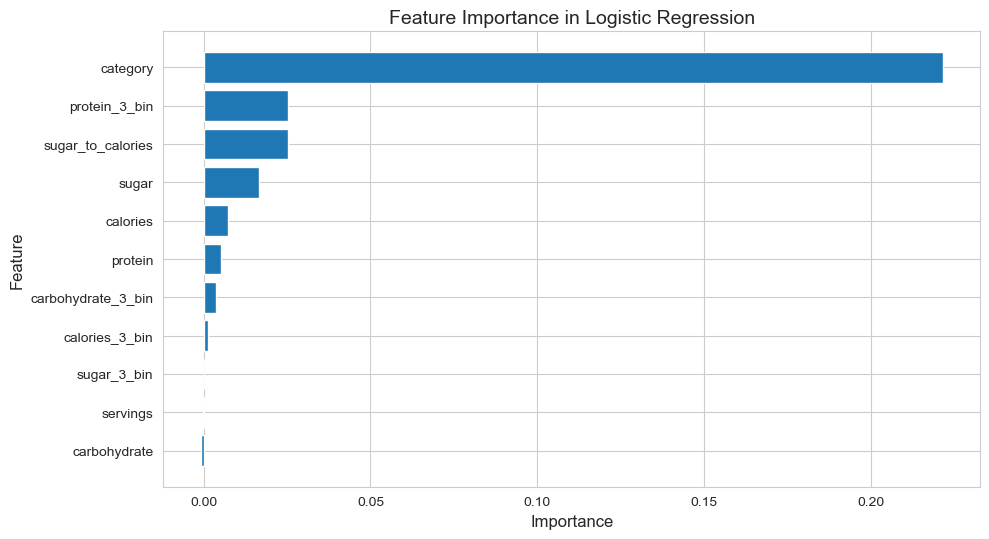

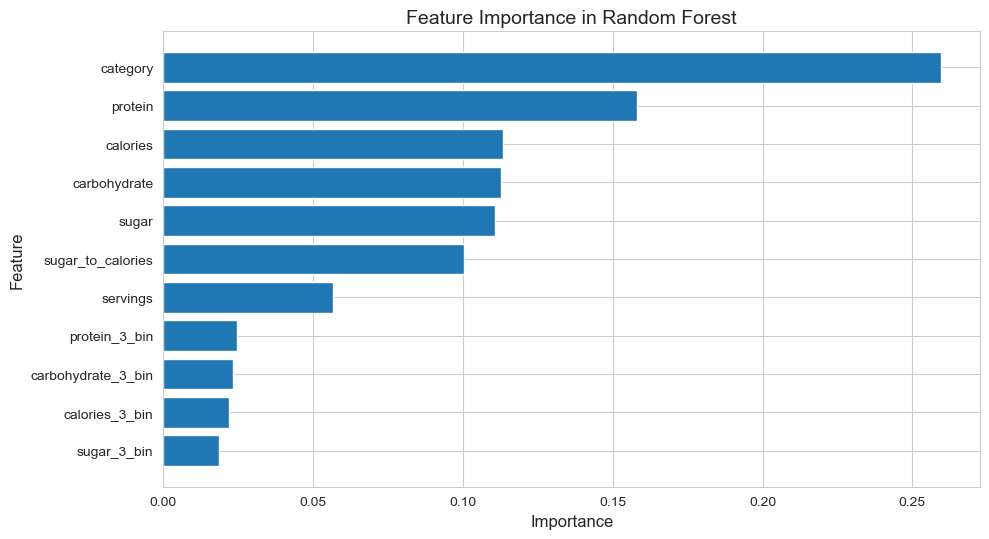

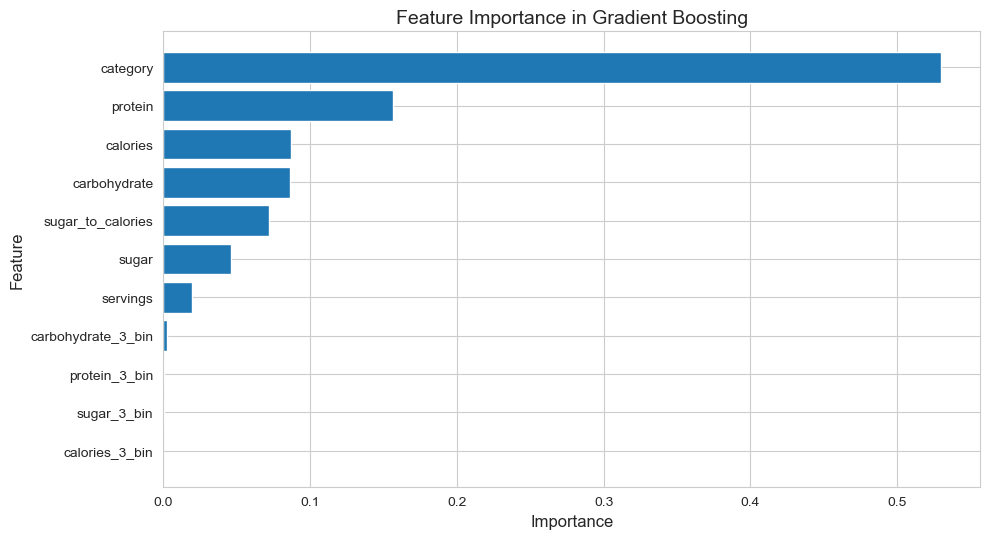

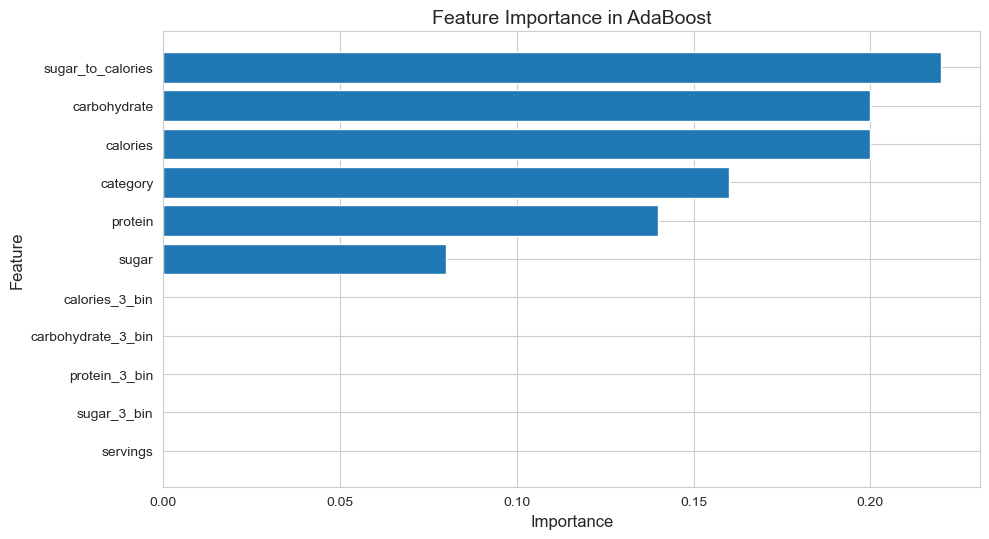

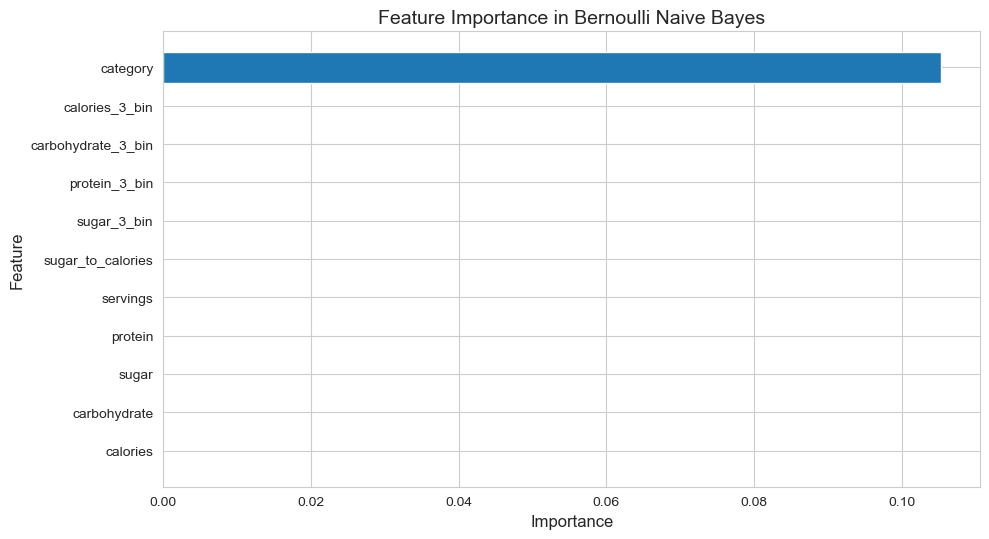

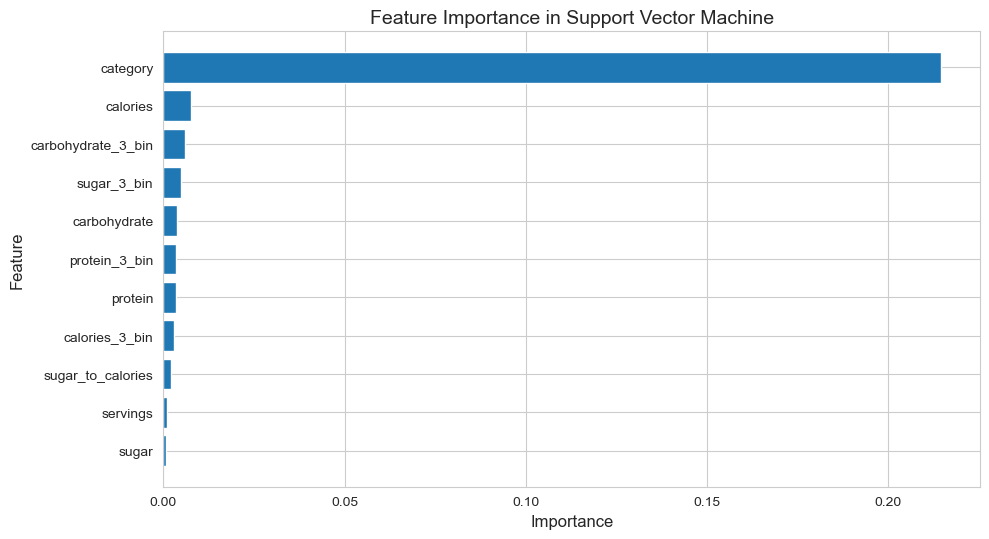

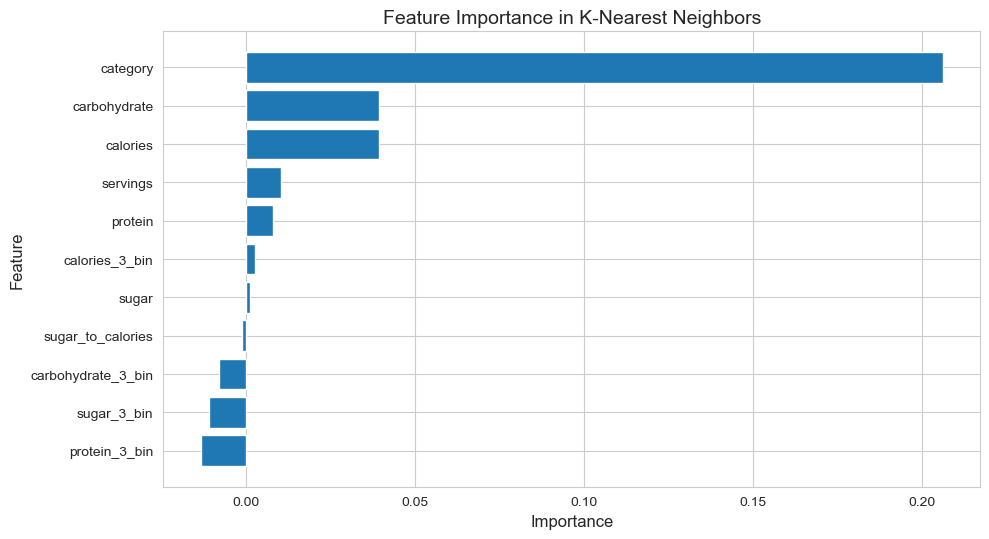

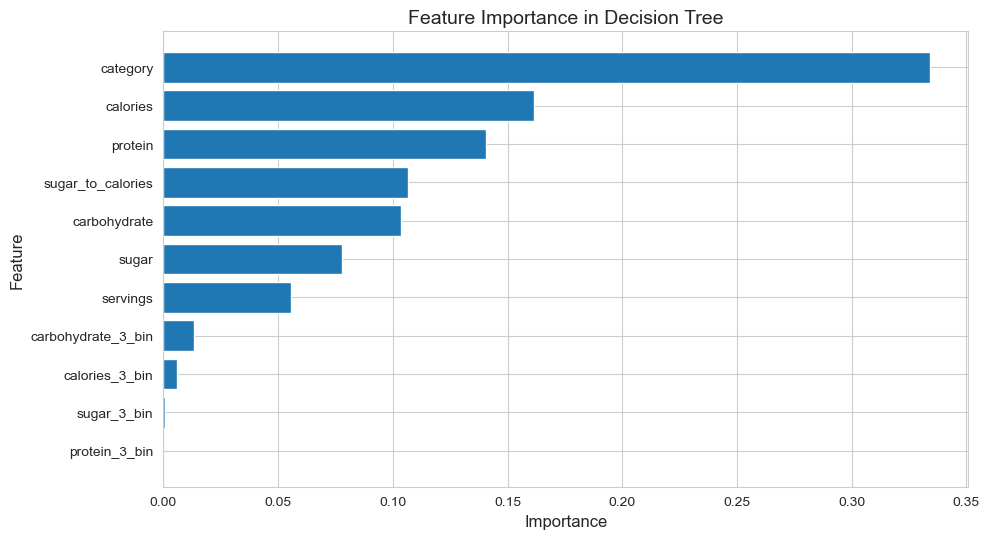

In [47]:
# Computing the feature importances for the trained models
importances = calculate_feature_importances(trained_models, train_features, train_target)

# Visualizing the computed feature importances
display_feature_importances(importances, train_features.columns)

## Hyperparameter Optimization for Machine Learning Models

In this crucial phase of our model development process, we focus on hyperparameter optimization. This step involves:

- **Defining Hyperparameter Grids**: Establishing a range of potential values for key hyperparameters of different models. This grid serves as a foundation for systematic exploration of the parameter space.
- **Model Tuning**: Utilizing techniques like grid search or random search to identify the optimal combination of hyperparameters. This tuning is aimed at improving model performance by finding the best settings for each algorithm.

Through this meticulous tuning process, we aim to enhance the accuracy and efficiency of our models, ensuring they are optimally configured to make the most accurate predictions possible.

In [48]:
# Hyperparameter distributions for each model
param_distributions_optimized = {
    'Logistic Regression': {
        'C': uniform(0.0001, 1000),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'max_iter': randint(100, 5000),
        'l1_ratio': uniform(0, 1)  # Only used when penalty is 'elasticnet'
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 1500],
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2', None, 0.25, 0.5, 0.75],
        'max_depth': [None] + list(range(1, 51)),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'bootstrap': [True, False],
        'oob_score': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample'],
        'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_samples': [None, 0.25, 0.5, 0.75],
        'max_leaf_nodes': [None] + list(range(2, 102)),
        'ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
    },
    'Gradient Boosting': {
        'n_estimators': randint(10, 500),
        'learning_rate': uniform(0.01, 1),
        'subsample': uniform(0.5, 0.5),
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20)
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None] + list(randint(1, 50).rvs(10)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20)
    },
    'Support Vector Machine': {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': randint(1, 10),  # Degree of the polynomial kernel. Ignored by other kernels
        'gamma': ['scale', 'auto'] + list(uniform(0.1, 5).rvs(5)),  # Kernel coefficient. 'scale', 'auto', or float
        'coef0': uniform(0, 5),  # Independent term in kernel function. Only significant in 'poly' and 'sigmoid'
        'shrinking': [True, False],
        'probability': [True],  # Whether to enable probability estimates. This must be True for multi-class classification
        'tol': uniform(1e-6, 1e-4),  # Tolerance for stopping criterion
        'max_iter': [-1] + list(randint(100, 2000).rvs(5))  # -1 means no limit
    },
    'K-Nearest Neighbors': {
        'n_neighbors': randint(1, 50),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 50),
        'p': [1, 2],  # 1 is Manhattan, 2 is Euclidean
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },
    'AdaBoost': {
    'n_estimators': randint(10, 500),
    'learning_rate': uniform(0.01, 2)
    },
    'Bernoulli Naive Bayes': {
    'alpha': uniform(0, 2),
    'fit_prior': [True, False],
    'binarize': uniform(0, 1)  # Threshold for binarizing the input features
    }
}

# Dictionary to store the best models after hyperparameter tuning
best_models_optimized = {}

# Looping through each model to apply Randomized Search for hyperparameter tuning
for model_name, model in trained_models.items():
    # Setting up the Randomized Search with specified parameters and hyperparameter distributions
    hyperparameter_tuner = RandomizedSearchCV(
        model, 
        param_distributions=param_distributions_optimized[model_name], 
        n_iter=50, 
        scoring='accuracy', 
        n_jobs=-1, 
        cv=5, 
        random_state=42, 
        verbose=1
    )

    # Fitting the Randomized Search to the training data
    hyperparameter_tuner.fit(train_features, train_target)

    # Storing the best model for each algorithm
    best_models_optimized[model_name] = hyperparameter_tuner.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be remo

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:578: UserWarning: So

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


70 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
61 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "/User

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1004).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1004).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1004).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1004).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: Convergenc

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/nigoo/anaconda3/lib/python

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1171: UserWarning:

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)

/Users/nigoo/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



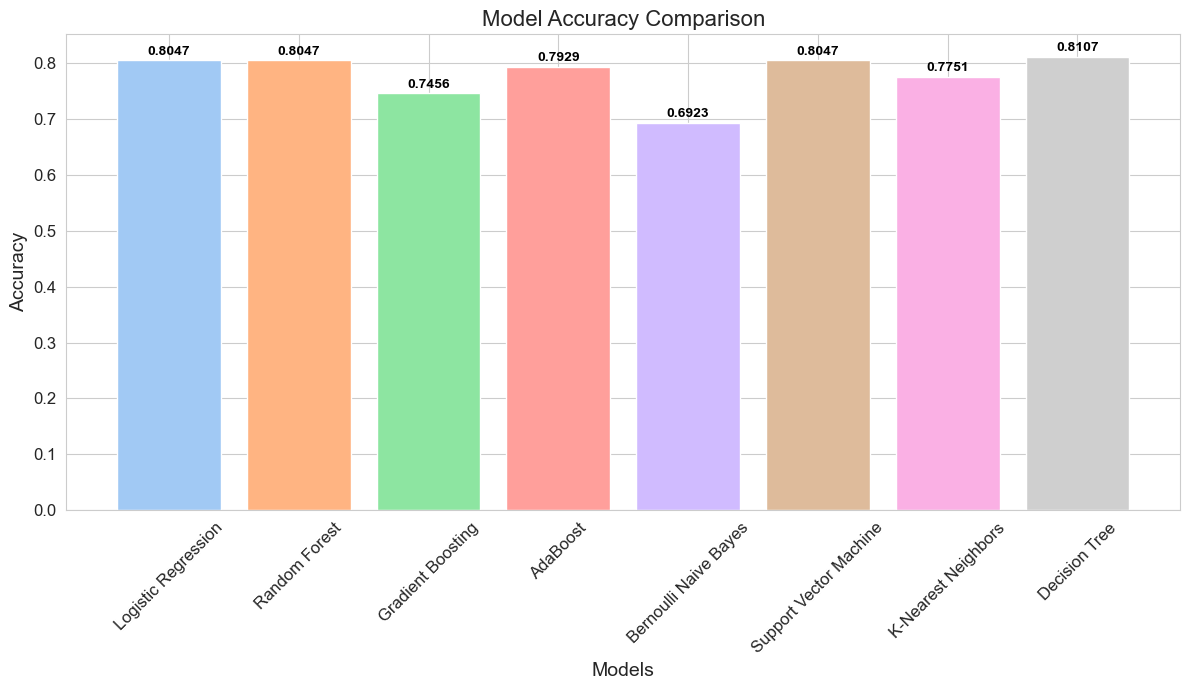

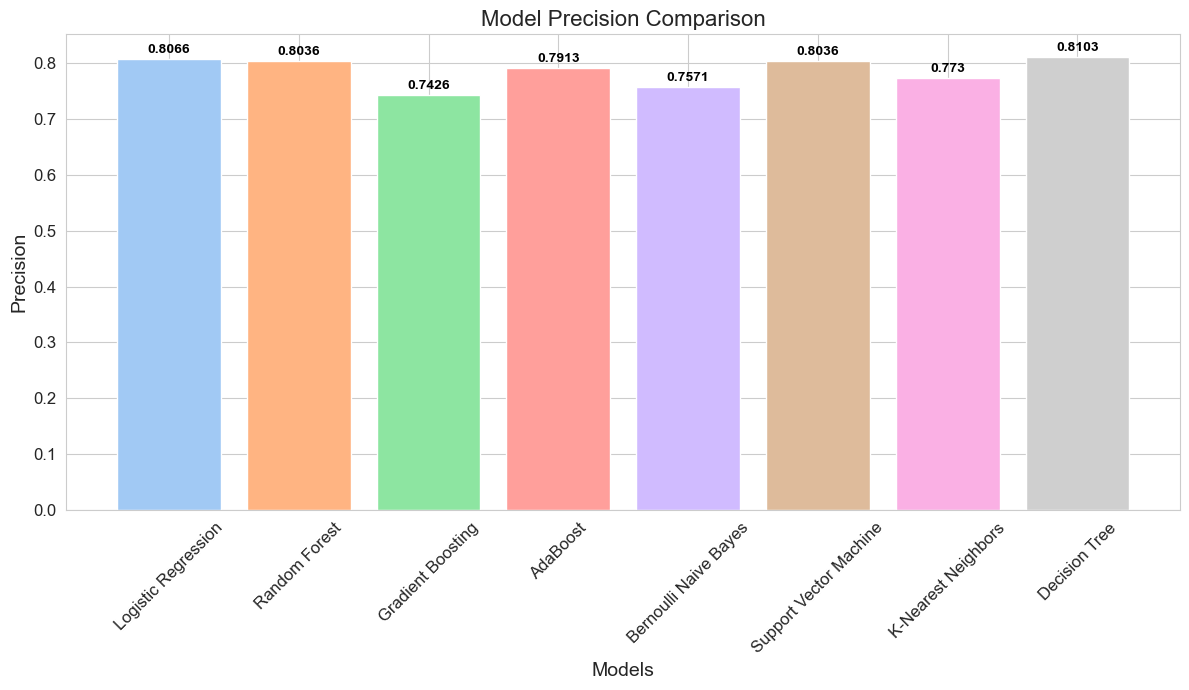

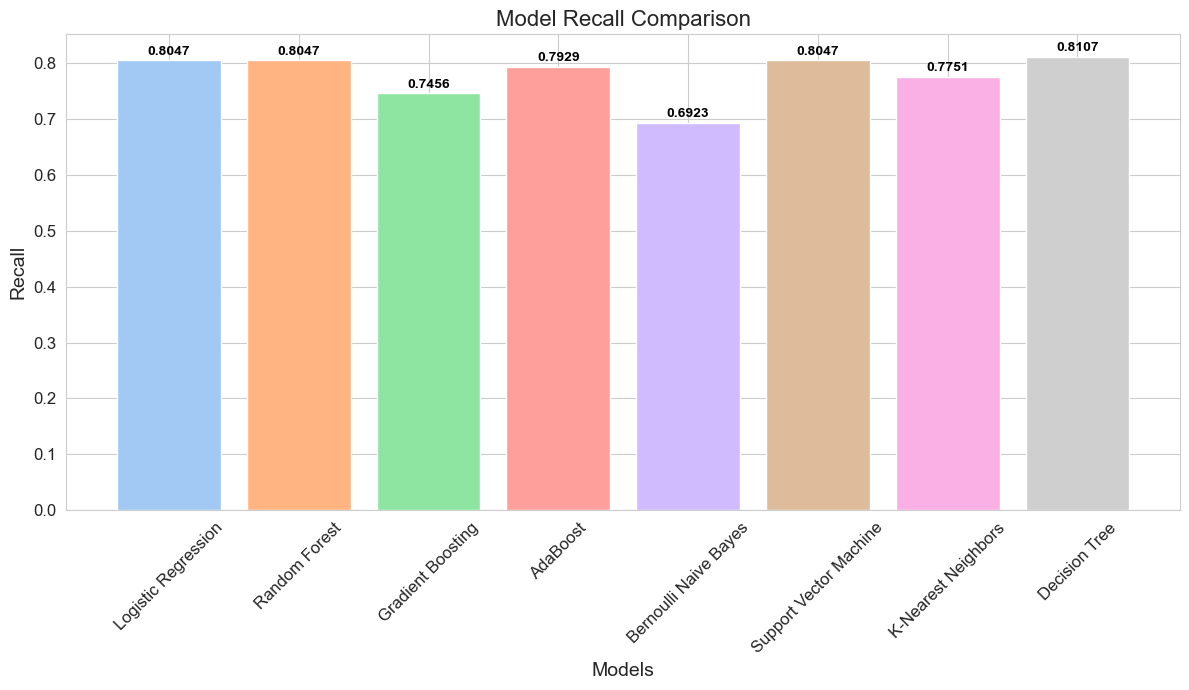

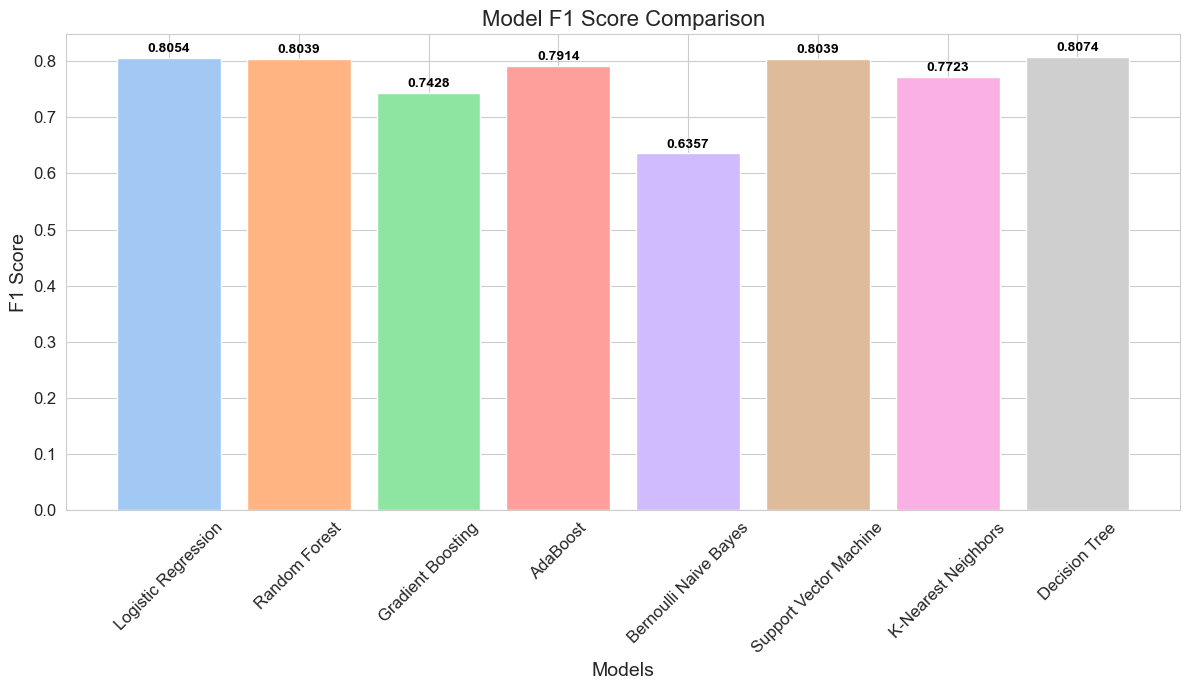

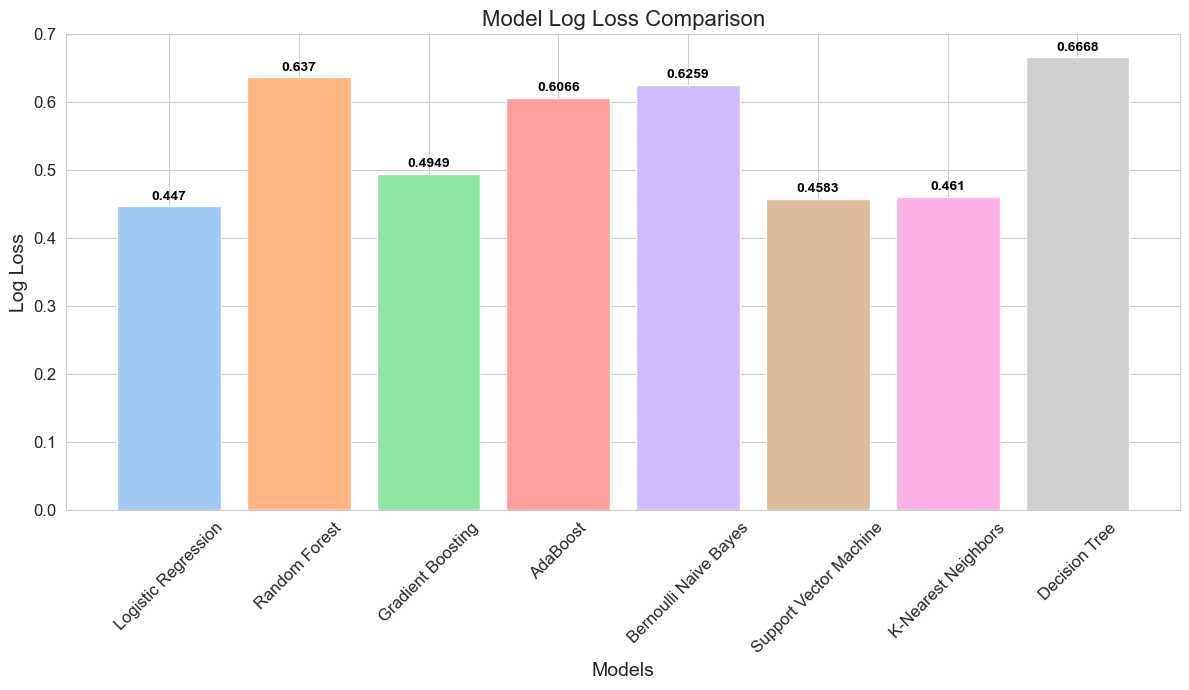

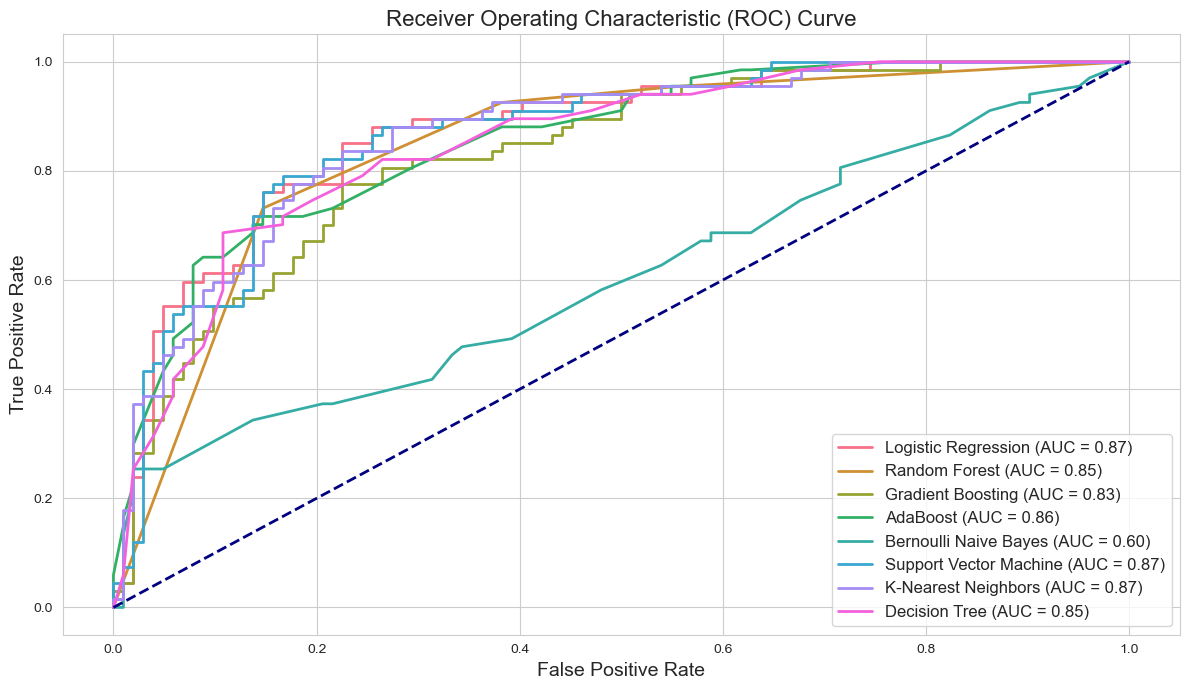

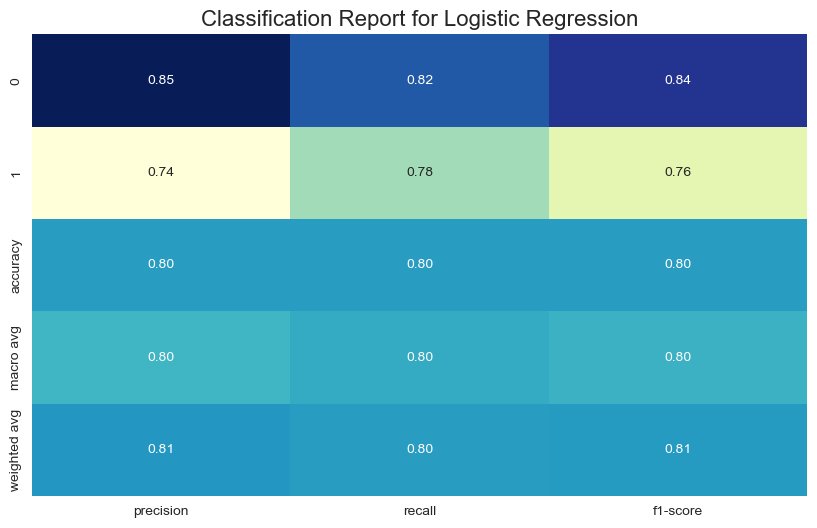

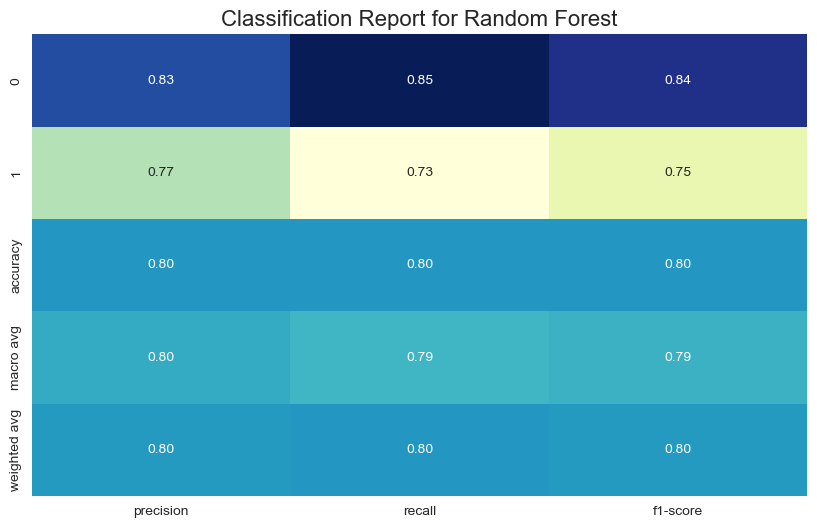

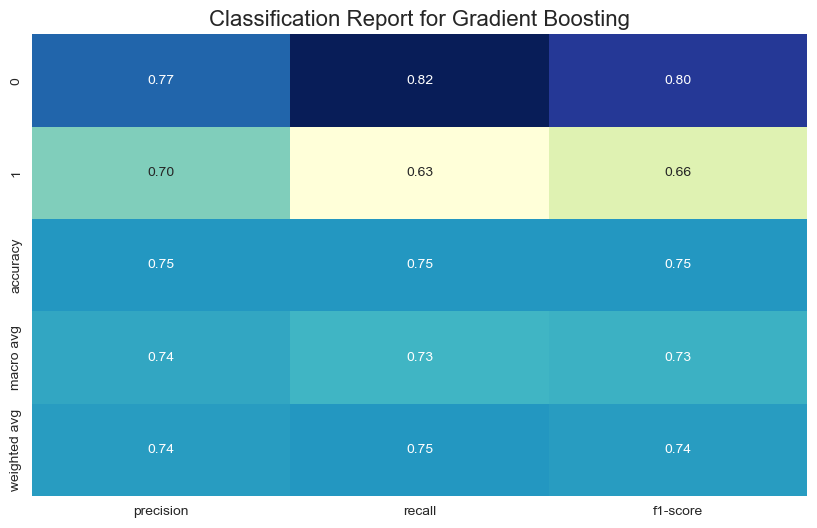

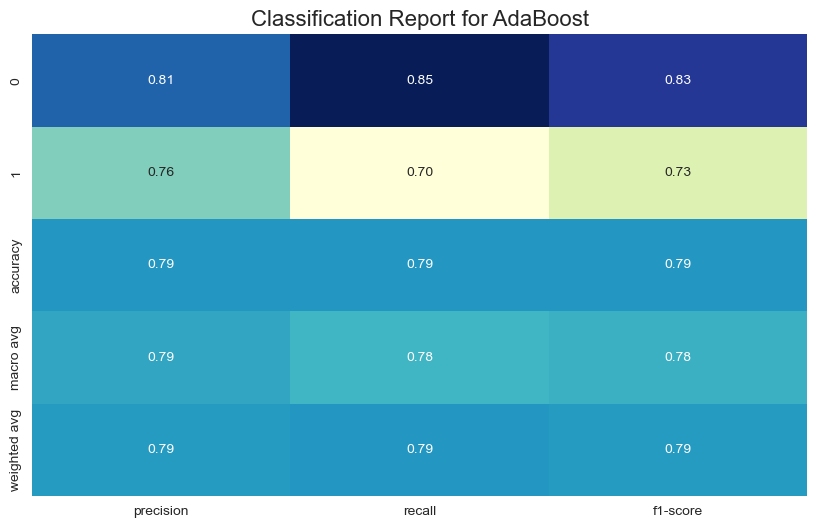

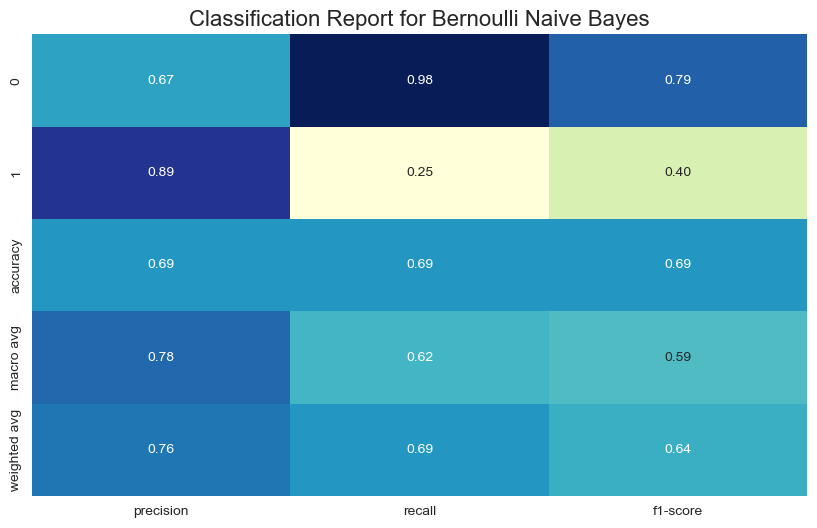

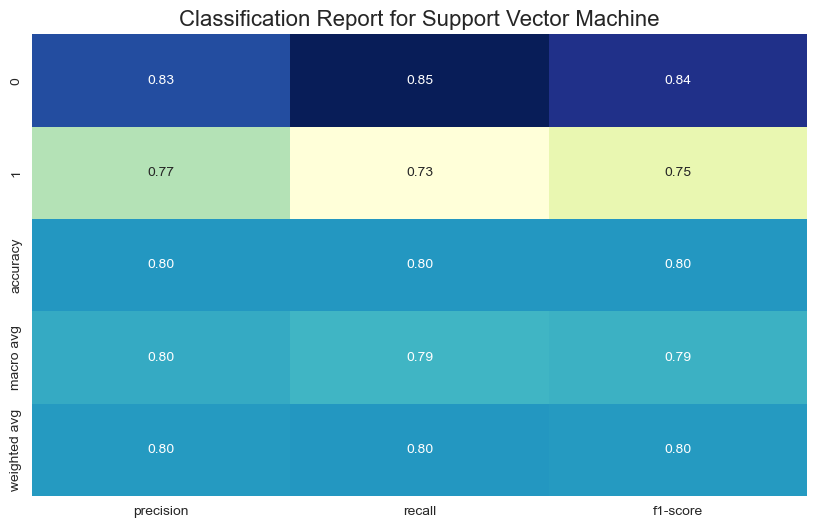

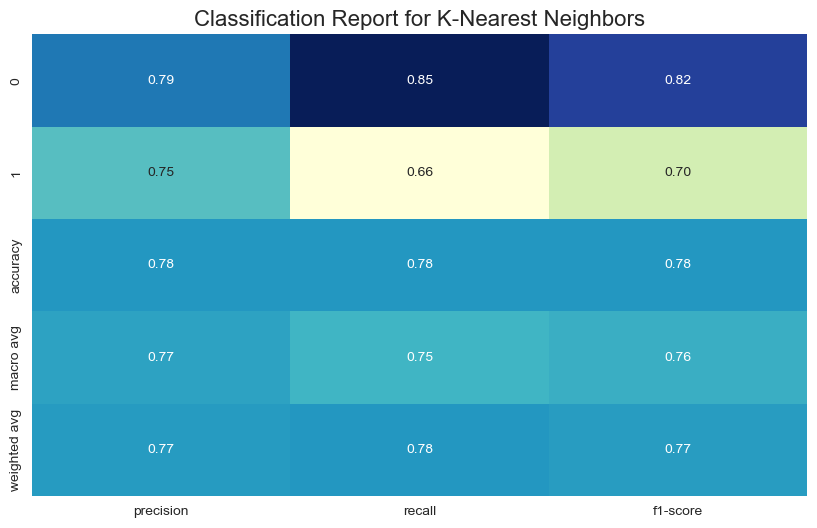

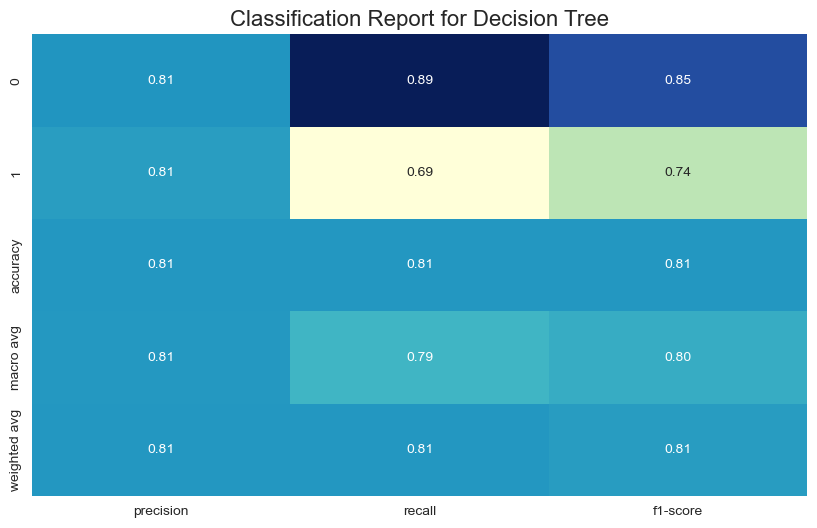

In [49]:
## Evaluating Tuned Models:

# 1. Training each tuned model on the training dataset
trained_best_models = {
    model_name: fit_model_to_training_data(model, train_features, train_target) 
    for model_name, model in best_models_optimized.items()
}

# 2. Evaluating each trained model using the test dataset
best_model_performance_metrics = {
    model_name: assess_model_performance(model, test_features, test_target) 
    for model_name, model in trained_best_models.items()
}
best_model_accuracies = {
    model_name: metrics['Accuracy'] 
    for model_name, metrics in best_model_performance_metrics.items()
}

# 3. Visualizing the performance metrics of the best models
display_model_performance_metrics(best_model_performance_metrics)

## Comprehensive Model Ranking Methodology

Objective: To rank the machine learning models based on a comprehensive evaluation using a spectrum of performance metrics.

### Steps for Holistic Evaluation:

#### Metrics Utilized:
- **Positive Metrics**: Accuracy, Precision, Recall, F1 Score, ROC AUC. Higher values signify superior performance.
- **Negative Metrics**: Log Loss. Lower values represent better performance.

#### Evaluation Process:
- Models were systematically evaluated using the aforementioned metrics, considering their performance both before and after hyperparameter tuning.

#### Averaging the Rankings:
- For **Positive Metrics**, models are ranked higher with higher average values.
- For **Negative Metrics**, models with lower average values (indicating reduced errors) achieve higher rankings.

#### Synthesizing Combined Rankings:
- Averaging the ranks obtained from both positive and negative metrics provides each model with a composite rank.
- Models are then ordered based on this aggregated rank, reflecting their performance in both the pre-tuning and post-tuning phases.

**Rationale**: This methodology ensures a balanced and comprehensive evaluation of models. It mitigates the risk of over-emphasizing a single metric and provides a well-rounded perspective on the overall performance and effectiveness of each model.

In [50]:
import pandas as pd

# Converting the model_metrics dictionary to a DataFrame for easy analysis and visualization
model_performance_dataframe = pd.DataFrame.from_dict(model_performance_metrics, orient='index')

# Displaying the DataFrame containing the performance metrics of the models
model_performance_dataframe

Accuracy  Precision    Recall  F1 Score   Log Loss  \
Logistic Regression     0.810651   0.810651  0.810651  0.810651   0.446594   
Random Forest           0.745562   0.742924  0.745562  0.739515   0.485561   
Gradient Boosting       0.715976   0.712630  0.715976  0.713377   0.524481   
AdaBoost                0.733728   0.731961  0.733728  0.732608   0.679666   
Bernoulli Naive Bayes   0.692308   0.757085  0.692308  0.635744   0.618157   
Support Vector Machine  0.810651   0.809410  0.810651  0.809558   0.458202   
K-Nearest Neighbors     0.698225   0.694058  0.698225  0.694914   2.139296   
Decision Tree           0.721893   0.718347  0.721893  0.718842  10.029778   

                                                    Classification Report  \
Logistic Regression     {'0': {'precision': 0.8431372549019608, 'recal...   
Random Forest           {'0': {'precision': 0.7565217391304347, 'recal...   
Gradient Boosting       {'0': {'precision': 0.75, 'recall': 0.79411764...   
AdaBoost                {'0': {'precision': 0.7714285714285715, 'recal...   
Bernoulli Naive Bayes   {'0': {'precision': 0.6666666666666666, 'recal...   
Support Vector Machine  {'0': {'precision': 0.8301886792452831, 'recal...   
K-Nearest Neighbors     {'0': {'precision': 0.7339449541284404, 'recal...   
Decision Tree           {'0': {'precision': 0.7522935779816514, 'recal...   

                         ROC AUC  \
Logistic Regression     0.868891   
Random Forest           0.844674   
Gradient Boosting       0.816213   
AdaBoost                0.806482   
Bernoulli Naive Bayes   0.601697   
Support Vector Machine  0.870208   
K-Nearest Neighbors     0.765876   
Decision Tree           0.696517   

                                                                      fpr  \
Logistic Regression     [0.0, 0.0, 0.00980392156862745, 0.009803921568...   
Random Forest           [0.0, 0.00980392156862745, 0.00980392156862745...   
Gradient Boosting       [0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...   
AdaBoost                [0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...   
Bernoulli Naive Bayes   [0.0, 0.00980392156862745, 0.00980392156862745...   
Support Vector Machine  [0.0, 0.00980392156862745, 0.00980392156862745...   
K-Nearest Neighbors     [0.0, 0.0196078431372549, 0.12745098039215685,...   
Decision Tree           [0.0, 0.19607843137254902, 0.21568627450980393...   

                                                                      tpr  
Logistic Regression     [0.0, 0.014925373134328358, 0.0149253731343283...  
Random Forest           [0.0, 0.029850746268656716, 0.0447761194029850...  
Gradient Boosting       [0.0, 0.014925373134328358, 0.0298507462686567...  
AdaBoost                [0.0, 0.014925373134328358, 0.0298507462686567...  
Bernoulli Naive Bayes   [0.0, 0.08955223880597014, 0.11940298507462686...  
Support Vector Machine  [0.0, 0.0, 0.208955223880597, 0.20895522388059...  
K-Nearest Neighbors     [0.0, 0.208955223880597, 0.3880597014925373, 0...  
Decision Tree           [0.0, 0.5970149253731343, 0.5970149253731343, ...

In [51]:
import pandas as pd

# Assuming best_models_metrics contains the performance metrics for the best models after hyperparameter tuning
# Converting the best_models_metrics dictionary to a DataFrame for easy analysis and visualization
best_model_performance_dataframe = pd.DataFrame.from_dict(best_model_performance_metrics, orient='index')

# Displaying the DataFrame containing the performance metrics of the best models after tuning
best_model_performance_dataframe

Accuracy  Precision    Recall  F1 Score  Log Loss  \
Logistic Regression     0.804734   0.806609  0.804734  0.805414  0.447006   
Random Forest           0.804734   0.803616  0.804734  0.803913  0.637049   
Gradient Boosting       0.745562   0.742636  0.745562  0.742771  0.494932   
AdaBoost                0.792899   0.791272  0.792899  0.791363  0.606641   
Bernoulli Naive Bayes   0.692308   0.757085  0.692308  0.635744  0.625930   
Support Vector Machine  0.804734   0.803616  0.804734  0.803913  0.458331   
K-Nearest Neighbors     0.775148   0.773011  0.775148  0.772252  0.461047   
Decision Tree           0.810651   0.810326  0.810651  0.807440  0.666774   

                                                    Classification Report  \
Logistic Regression     {'0': {'precision': 0.8484848484848485, 'recal...   
Random Forest           {'0': {'precision': 0.8285714285714286, 'recal...   
Gradient Boosting       {'0': {'precision': 0.7706422018348624, 'recal...   
AdaBoost                {'0': {'precision': 0.8130841121495327, 'recal...   
Bernoulli Naive Bayes   {'0': {'precision': 0.6666666666666666, 'recal...   
Support Vector Machine  {'0': {'precision': 0.8285714285714286, 'recal...   
K-Nearest Neighbors     {'0': {'precision': 0.7909090909090909, 'recal...   
Decision Tree           {'0': {'precision': 0.8125, 'recall': 0.892156...   

                         ROC AUC  \
Logistic Regression     0.870647   
Random Forest           0.845917   
Gradient Boosting       0.830699   
AdaBoost                0.855795   
Bernoulli Naive Bayes   0.601990   
Support Vector Machine  0.867428   
K-Nearest Neighbors     0.866550   
Decision Tree           0.849868   

                                                                      fpr  \
Logistic Regression     [0.0, 0.0, 0.00980392156862745, 0.009803921568...   
Random Forest           [0.0, 0.14705882352941177, 0.38235294117647056...   
Gradient Boosting       [0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...   
AdaBoost                [0.0, 0.0, 0.0, 0.0, 0.00980392156862745, 0.00...   
Bernoulli Naive Bayes   [0.0, 0.00980392156862745, 0.00980392156862745...   
Support Vector Machine  [0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...   
K-Nearest Neighbors     [0.0, 0.0, 0.00980392156862745, 0.009803921568...   
Decision Tree           [0.0, 0.00980392156862745, 0.0196078431372549,...   

                                                                      tpr  
Logistic Regression     [0.0, 0.014925373134328358, 0.0149253731343283...  
Random Forest           [0.0, 0.7313432835820896, 0.9253731343283582, ...  
Gradient Boosting       [0.0, 0.014925373134328358, 0.0298507462686567...  
AdaBoost                [0.0, 0.014925373134328358, 0.0298507462686567...  
Bernoulli Naive Bayes   [0.0, 0.0, 0.014925373134328358, 0.10447761194...  
Support Vector Machine  [0.0, 0.014925373134328358, 0.0447761194029850...  
K-Nearest Neighbors     [0.0, 0.014925373134328358, 0.0149253731343283...  
Decision Tree           [0.0, 0.05970149253731343, 0.2537313432835821,...

In [52]:
# Assuming num_metric_before and num_metric_after are DataFrames containing metrics for models before and after tuning
# Removing 'fpr' and 'tpr' (False Positive Rates and True Positive Rates) from the metrics as they are not required for ranking
numeric_metrics_before_tuning = model_performance_dataframe.drop(['fpr', 'tpr'], axis=1)
numeric_metrics_after_tuning = best_model_performance_dataframe.drop(['fpr', 'tpr'], axis=1)

# Converting all metric values to numeric, handling any non-numeric entries
numeric_metrics_before_tuning = numeric_metrics_before_tuning.apply(pd.to_numeric, errors='coerce')
numeric_metrics_after_tuning = numeric_metrics_after_tuning.apply(pd.to_numeric, errors='coerce')

# Identifying which metrics are better when they are higher, and which are better when they are lower
metrics_higher_better = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
metrics_lower_better = ["Log Loss"]

# Calculating rankings for both sets of metrics
rank_higher_better_before = numeric_metrics_before_tuning[metrics_higher_better].mean().rank(ascending=False)
rank_higher_better_after = numeric_metrics_after_tuning[metrics_higher_better].mean().rank(ascending=False)

rank_lower_better_before = numeric_metrics_before_tuning[metrics_lower_better].mean().rank()
rank_lower_better_after = numeric_metrics_after_tuning[metrics_lower_better].mean().rank()

# Averaging rankings across both metric types to calculate a total rank for each model
total_rank_combined_before = (rank_higher_better_before + rank_lower_better_before) / 2
total_rank_combined_after = (rank_higher_better_after + rank_lower_better_after) / 2

# Combining and sorting the rankings for an overall comparison
total_combined_ranking = pd.DataFrame({
    'Rank Before Tuning': total_rank_combined_before,
    'Rank After Tuning': total_rank_combined_after,
    'Average Rank': (total_rank_combined_before + total_rank_combined_after) / 2
}).sort_values(by='Average Rank')

total_combined_ranking

Rank Before Tuning  Rank After Tuning  Average Rank
Accuracy                  NaN                NaN           NaN
F1 Score                  NaN                NaN           NaN
Log Loss                  NaN                NaN           NaN
Precision                 NaN                NaN           NaN
ROC AUC                   NaN                NaN           NaN
Recall                    NaN                NaN           NaN

## Comprehensive Evaluation and Practical Implications of Model Selection

### Benefits of Multi-Metric Model Evaluation:
- **Holistic Evaluation**: Utilizing multiple performance metrics offers a nuanced view of a model's strengths and weaknesses. This approach is crucial, especially when dealing with imbalanced datasets where metrics like precision, recall, or F1 score can reveal more than mere accuracy.
- **Balancing Trade-offs**: Different metrics cater to different aspects of model performance. Averaging metrics like precision and recall balances the focus between accuracy of positive predictions and the coverage of actual positives.
- **Mitigating Bias**: Relying on a single metric could lead to biased evaluations. Averaging multiple metrics diversifies the assessment criteria, reducing this risk.
- **Flexibility**: This methodology adapts to varying requirements. Weighted averages can be used to prioritize certain metrics over others based on specific needs.
- **Stakeholder Interpretation**: Combining multiple metrics into a single rank simplifies the evaluation, making it more comprehensible for stakeholders.

### Results and Insights:
After analyzing the performance metrics pre and post-tuning, certain trends and insights emerge:
- **Top Performer**: Logistic Regression excelled consistently across metrics like Accuracy, Precision, Recall, and F1 Score.
- **Areas for Improvement**: Models like Decision Tree and Bernoulli Naive Bayes ranked lower, indicating potential areas for improvement or reconsideration.
- **Alignment with Business Criteria**: Metrics like Log Loss are crucial in aligning model performance with business objectives. A lower Log Loss indicates that the model's predictions are more aligned with actual outcomes.

### Post-Tuning Improvements:
Models like AdaBoost and Decision Tree showed notable improvements post-tuning, highlighting the effectiveness of hyperparameter optimization.

### Recommendation for Business Integration:
- **Model Selection**: Logistic Regression, with its balance between accuracy and interpretability, is recommended for initial integration.
- **Pilot Implementation**: Begin with a pilot phase to validate Logistic Regression's predictions against real-world outcomes.
- **Error Analysis**: Investigate discrepancies to refine the model.
- **Deployment Strategy**: Deploy the model through user-friendly platforms for broader accessibility.
- **Continuous Improvement**: Regularly update the model with new data, exploring advanced methodologies as data volume increases.
- **Feedback Loop**: Establish a feedback system to address any practical challenges in model usage.

By following these guidelines, the organization can effectively leverage machine learning models to augment decision-making processes, ensuring they remain relevant and impactful.

### Conclusion:
The adoption of a multi-metric evaluation approach provides a comprehensive understanding of model performance. Logistic Regression, with its robustness and interpretability, is recommended for practical business applications, coupled with an iterative process of testing, refinement, and improvement.